# Required Imports and Constants

In [1]:
%matplotlib inline

import ast
import json
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches

from scipy.stats import f_oneway
from scipy.stats import ttest_1samp

import warnings
warnings.filterwarnings("ignore")


AYS_PIDS = [
      "0Odg8Ya9cQZM",
      "3Bl1l9qPo03v",
      "9BJDMrSg5GU2",
      "AtYKOM9xQoxo",
      "bvxCS2xslVD1",
      "bzdxtTFRW7bn",
      "Ck5zEa9jS8kr",
      "EPcW0vyMy901",
      "gzgUnyhhYvag",
      "kK7uC15Oxl7j",
      "WAiLZBXejqs6",
      "WBoN8OgUq9kM",
      "xrQxT9kE7trL",
]

SUM_PIDS = [
      "7YPaDt3k6zUJ",
      "9oAsM1Zsd2ZL",
      "BDsZoXY2KvCq",
      "cBx0ECEdnCXE",
      "DMMPwdh9JyIJ",
      "F8aaNjmqipm9",
      "iLi4QFTFUW6W",
      "KB4R9vQpgvDE",
      "n8dCqYoZqOtZ",
      "oa0dujnJJIQK",
      "Q3GODcr8rSU2",
      "Xb1da3tmq51s",
      "XK6R4nlN8DL9",
      "Xm4gLrMYjXLp",
]

RT_PIDS = [
      "3jCj03ExwbiR",
      "3LjPd26Bv20B",
      "7zspHOjpyZg6",
      "qBEgmP5F3go8",
      "RJozqLvmzUql",
      "SM3fpzR19vuY",
      "tqnTUO7mgIPw",
      "VSG8tghjg06Z",
      "wYKNw3brGUCM",
      "yJrWi90sw5Fv",
      "ZDOTBhGZ9oS9",
]

RTSUM_PIDS = [
      "1V7m8wY9JNak",
      "606gnDVdNwnt",
      "7UfOha66klmh",
      "DAn39rXtnCAS",
      "ggYz115dy0a9",
      "joO2OX6p9rr6",
      "rJwpqBcwhEar",
      "UPGk3s3Qldql",
      "vEiIrVSiezFn",
      "w6ptnTrqQi3D",
      "wJm4COpLVvz5",
      "zV0yHZRI3MH9"
]

ALL_PIDS = {
    'CTRL': AYS_PIDS,
    'SUM': SUM_PIDS,
    'RT': RT_PIDS,
    'RTSUM': RTSUM_PIDS,
}

# Attribute Focus Counts Across All Conditions

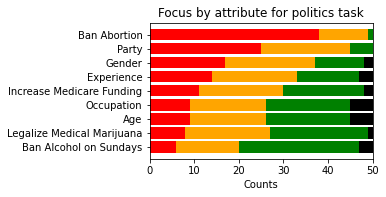

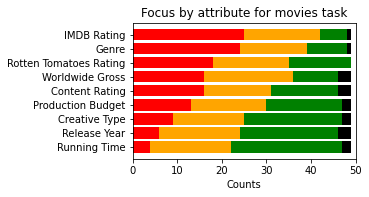

In [2]:
row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    dfs = []
    for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            # get file
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
            if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                # append surprise/focus counts
                dfs.append(
                    df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series).T[row_index[task]]
                        .map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series)
                        .reset_index()
                        .rename(columns={'index': 'attribute'})
                        .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                )

    # push the dataframes together
    surprise_focus = pd.concat(dfs, ignore_index=True)
    counts = (
        surprise_focus.groupby(['attribute', 'focus'])
            .size()
            .unstack(fill_value=0)[['high', 'medium', 'low', 'na']]
            .sort_values(by=['high', 'medium', 'low']).T
    )

    ### PLOT ### 

    plot_titles = {
        'politics': {
            'age': 'Age',
            'gender': 'Gender',
            'occupation': 'Occupation',
            'party': 'Party',
            'political_experience': 'Experience',
            'policy_strength_ban_abortion_after_6_weeks': 'Ban Abortion',
            'policy_strength_legalize_medical_marijuana': 'Legalize Medical Marijuana',
            'policy_strength_increase_medicare_funding': 'Increase Medicare Funding',
            'policy_strength_ban_alcohol_sales_sundays': 'Ban Alcohol on Sundays'
        },
        'movies': {
            "Running Time": "Running Time",
            "Production Budget": "Production Budget",
            "Worldwide Gross": "Worldwide Gross",
            "Rotten Tomatoes Rating": "Rotten Tomatoes Rating",
            "IMDB Rating": "IMDB Rating",
            "Genre": "Genre",
            "Creative Type": "Creative Type",
            "Content Rating": "Content Rating",
            "Release Year": "Release Year",
        }
    }


    fig, ax = plt.subplots(figsize=(4,2.5))

    vals = lambda x: counts.loc[x].tolist()
    labels = [plot_titles[task][key] for key in list(counts.columns)]

    ax.barh(labels, vals('high'), label='High', color='red')
    ax.barh(labels, vals('medium'), left=vals('high'), label='Medium', color='orange')
    ax.barh(labels, vals('low'), left=[sum(x) for x in zip(vals('high'), vals('medium'))], label='Low', color='green')
    ax.barh(labels, vals('na'), left=[sum(x) for x in zip(vals('high'), vals('medium'), vals('low'))], label='NA', color='black')

    ax.set_xlim([0, 50])
    ax.set_xlabel('Counts')
    ax.set_title(f'Focus by attribute for {task} task')

#     handles, labels = ax.get_legend_handles_labels()
#     handles.insert(0, plt.plot([],marker="", ls="")[0])
#     labels.insert(0, 'Focus')    
#     plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5)

#     plt.savefig(f'charts/surprise/{task}/{task}_focus_all_conditions.png', dpi=300, bbox_inches='tight')

# Attribute Surprise Counts Across All Conditions

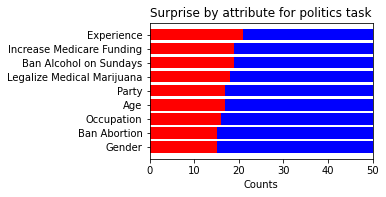

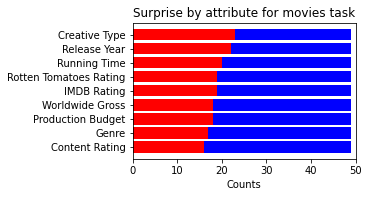

In [3]:
row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    dfs = []
    for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            # get file
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
            if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                # append surprise/focus counts
                dfs.append(
                    df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series).T[row_index[task]]
                        .map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series)
                        .reset_index()
                        .rename(columns={'index': 'attribute'})
                        .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                )

    # push the dataframes together
    surprise_focus = pd.concat(dfs, ignore_index=True)
    counts = (
        surprise_focus.groupby(['attribute', 'surprise'])
            .size()
            .unstack(fill_value=0)[['yes', 'no']]
            .sort_values(by=['yes', 'no']).T
    )
    
    ### PLOT ### 

    plot_titles = {
        'politics': {
            'age': 'Age',
            'gender': 'Gender',
            'occupation': 'Occupation',
            'party': 'Party',
            'political_experience': 'Experience',
            'policy_strength_ban_abortion_after_6_weeks': 'Ban Abortion',
            'policy_strength_legalize_medical_marijuana': 'Legalize Medical Marijuana',
            'policy_strength_increase_medicare_funding': 'Increase Medicare Funding',
            'policy_strength_ban_alcohol_sales_sundays': 'Ban Alcohol on Sundays'
        },
        'movies': {
            "Running Time": "Running Time",
            "Production Budget": "Production Budget",
            "Worldwide Gross": "Worldwide Gross",
            "Rotten Tomatoes Rating": "Rotten Tomatoes Rating",
            "IMDB Rating": "IMDB Rating",
            "Genre": "Genre",
            "Creative Type": "Creative Type",
            "Content Rating": "Content Rating",
            "Release Year": "Release Year",
        }
    }


    fig, ax = plt.subplots(figsize=(4,2.5))

    vals = lambda x: counts.loc[x].tolist()
    labels = [plot_titles[task][key] for key in list(counts.columns)]

    ax.barh(labels, vals('yes'), label='Yes', color='red')
    ax.barh(labels, vals('no'), left=vals('yes'), label='No', color='blue')

    ax.set_xlim([0, 50])
    ax.set_xlabel('Counts')
    ax.set_title(f'Surprise by attribute for {task} task')

#     plt.savefig(f'charts/surprise/{task}/{task}_surprise_all_conditions.png', dpi=300, bbox_inches='tight')

# Attribute Surprise Counts Grouped by Focus - For Each Condition - For Each Task

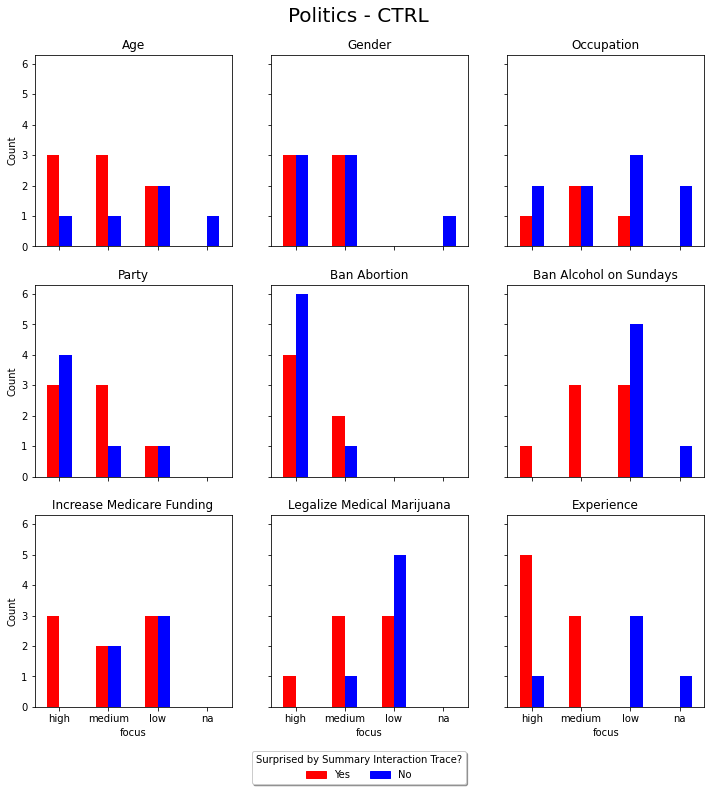

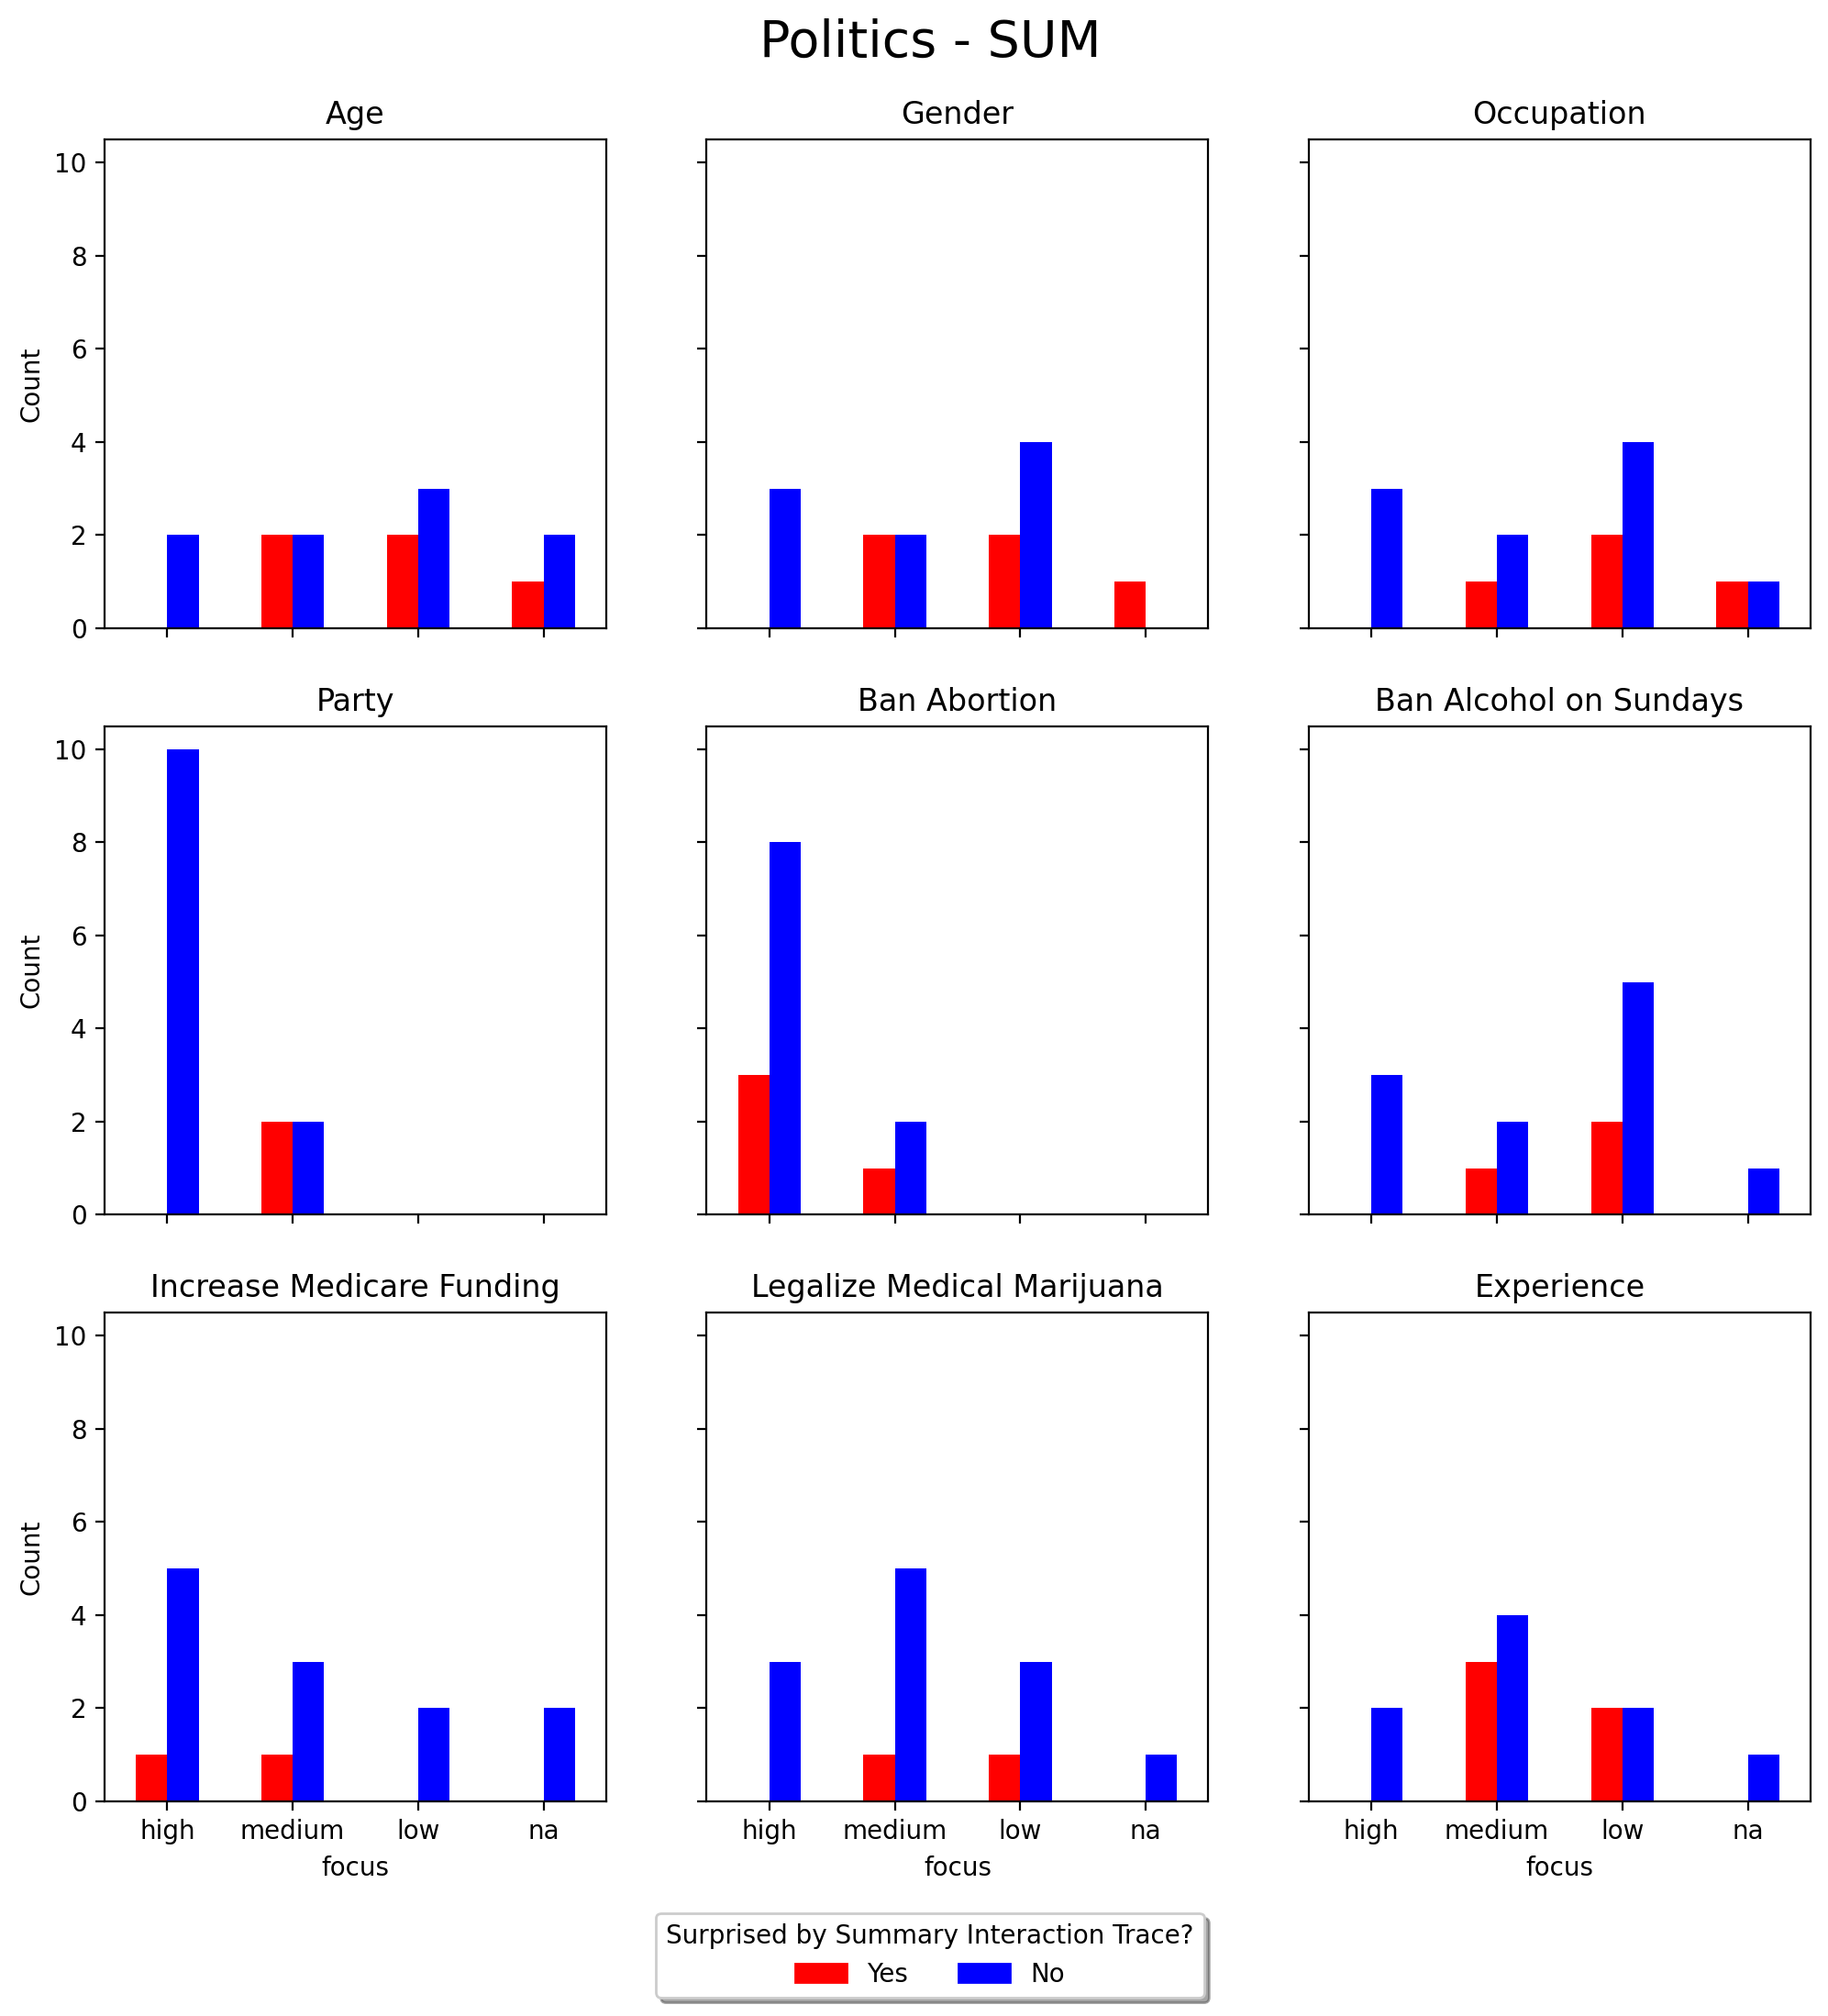

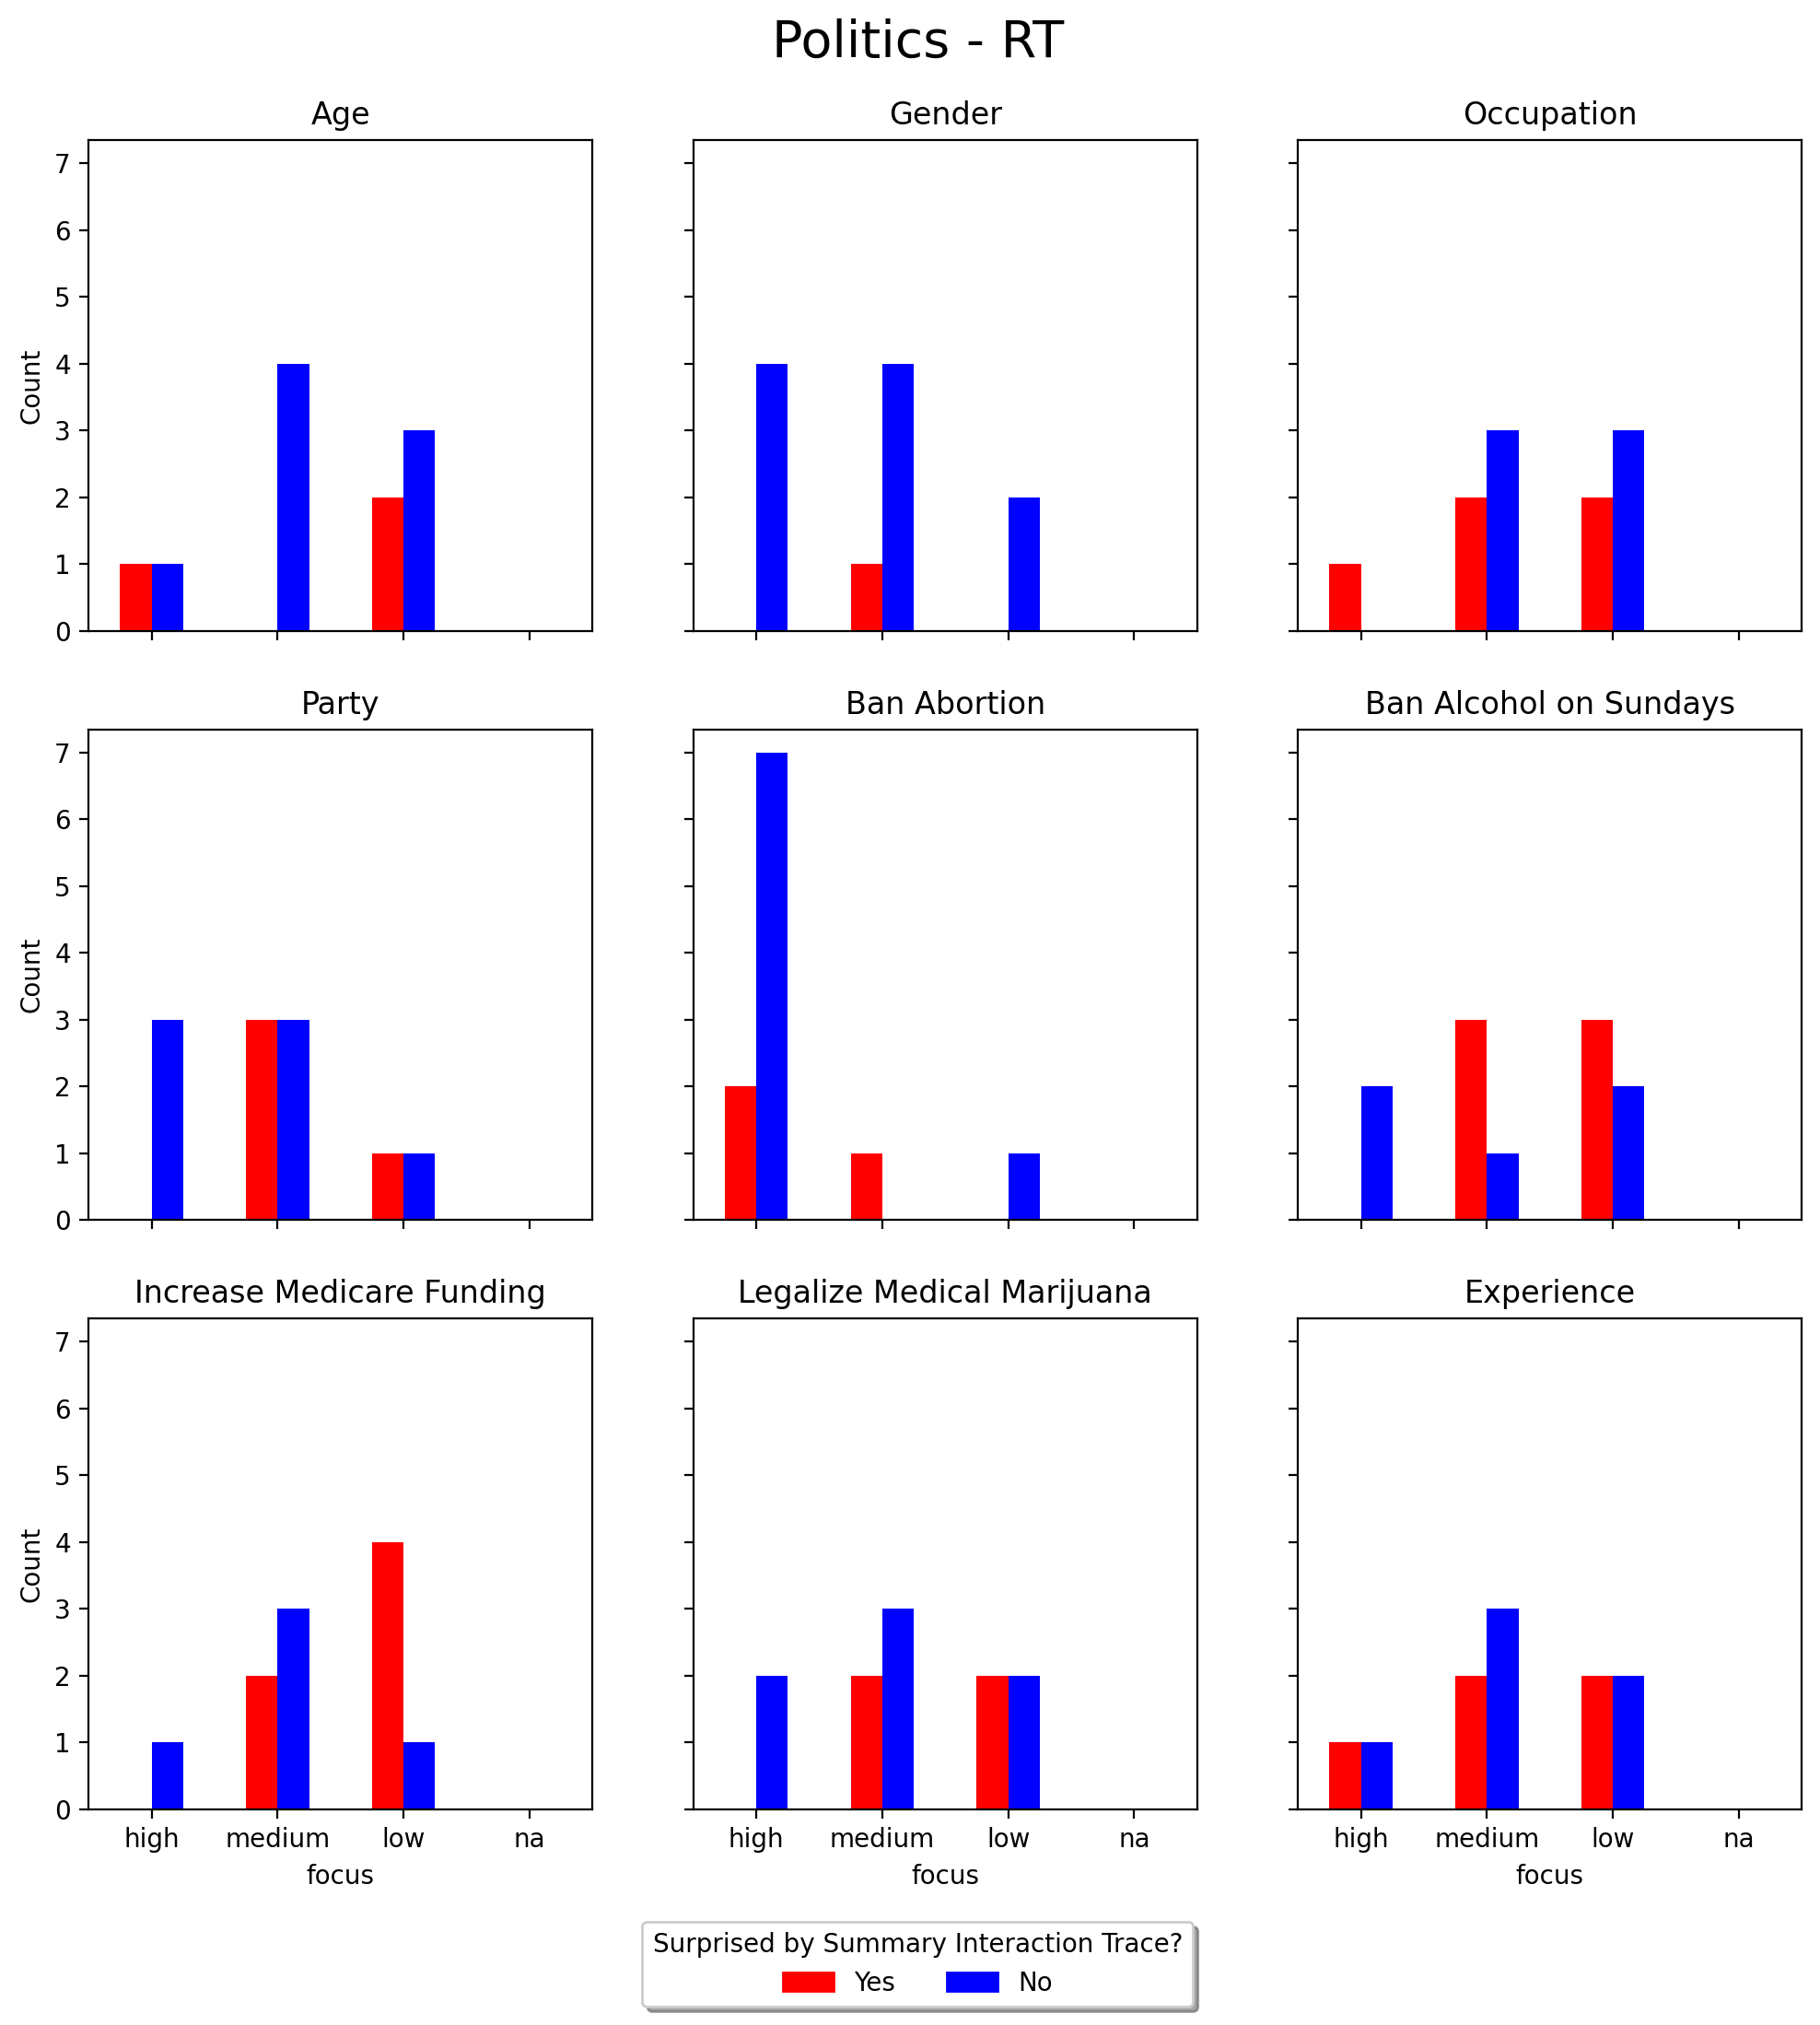

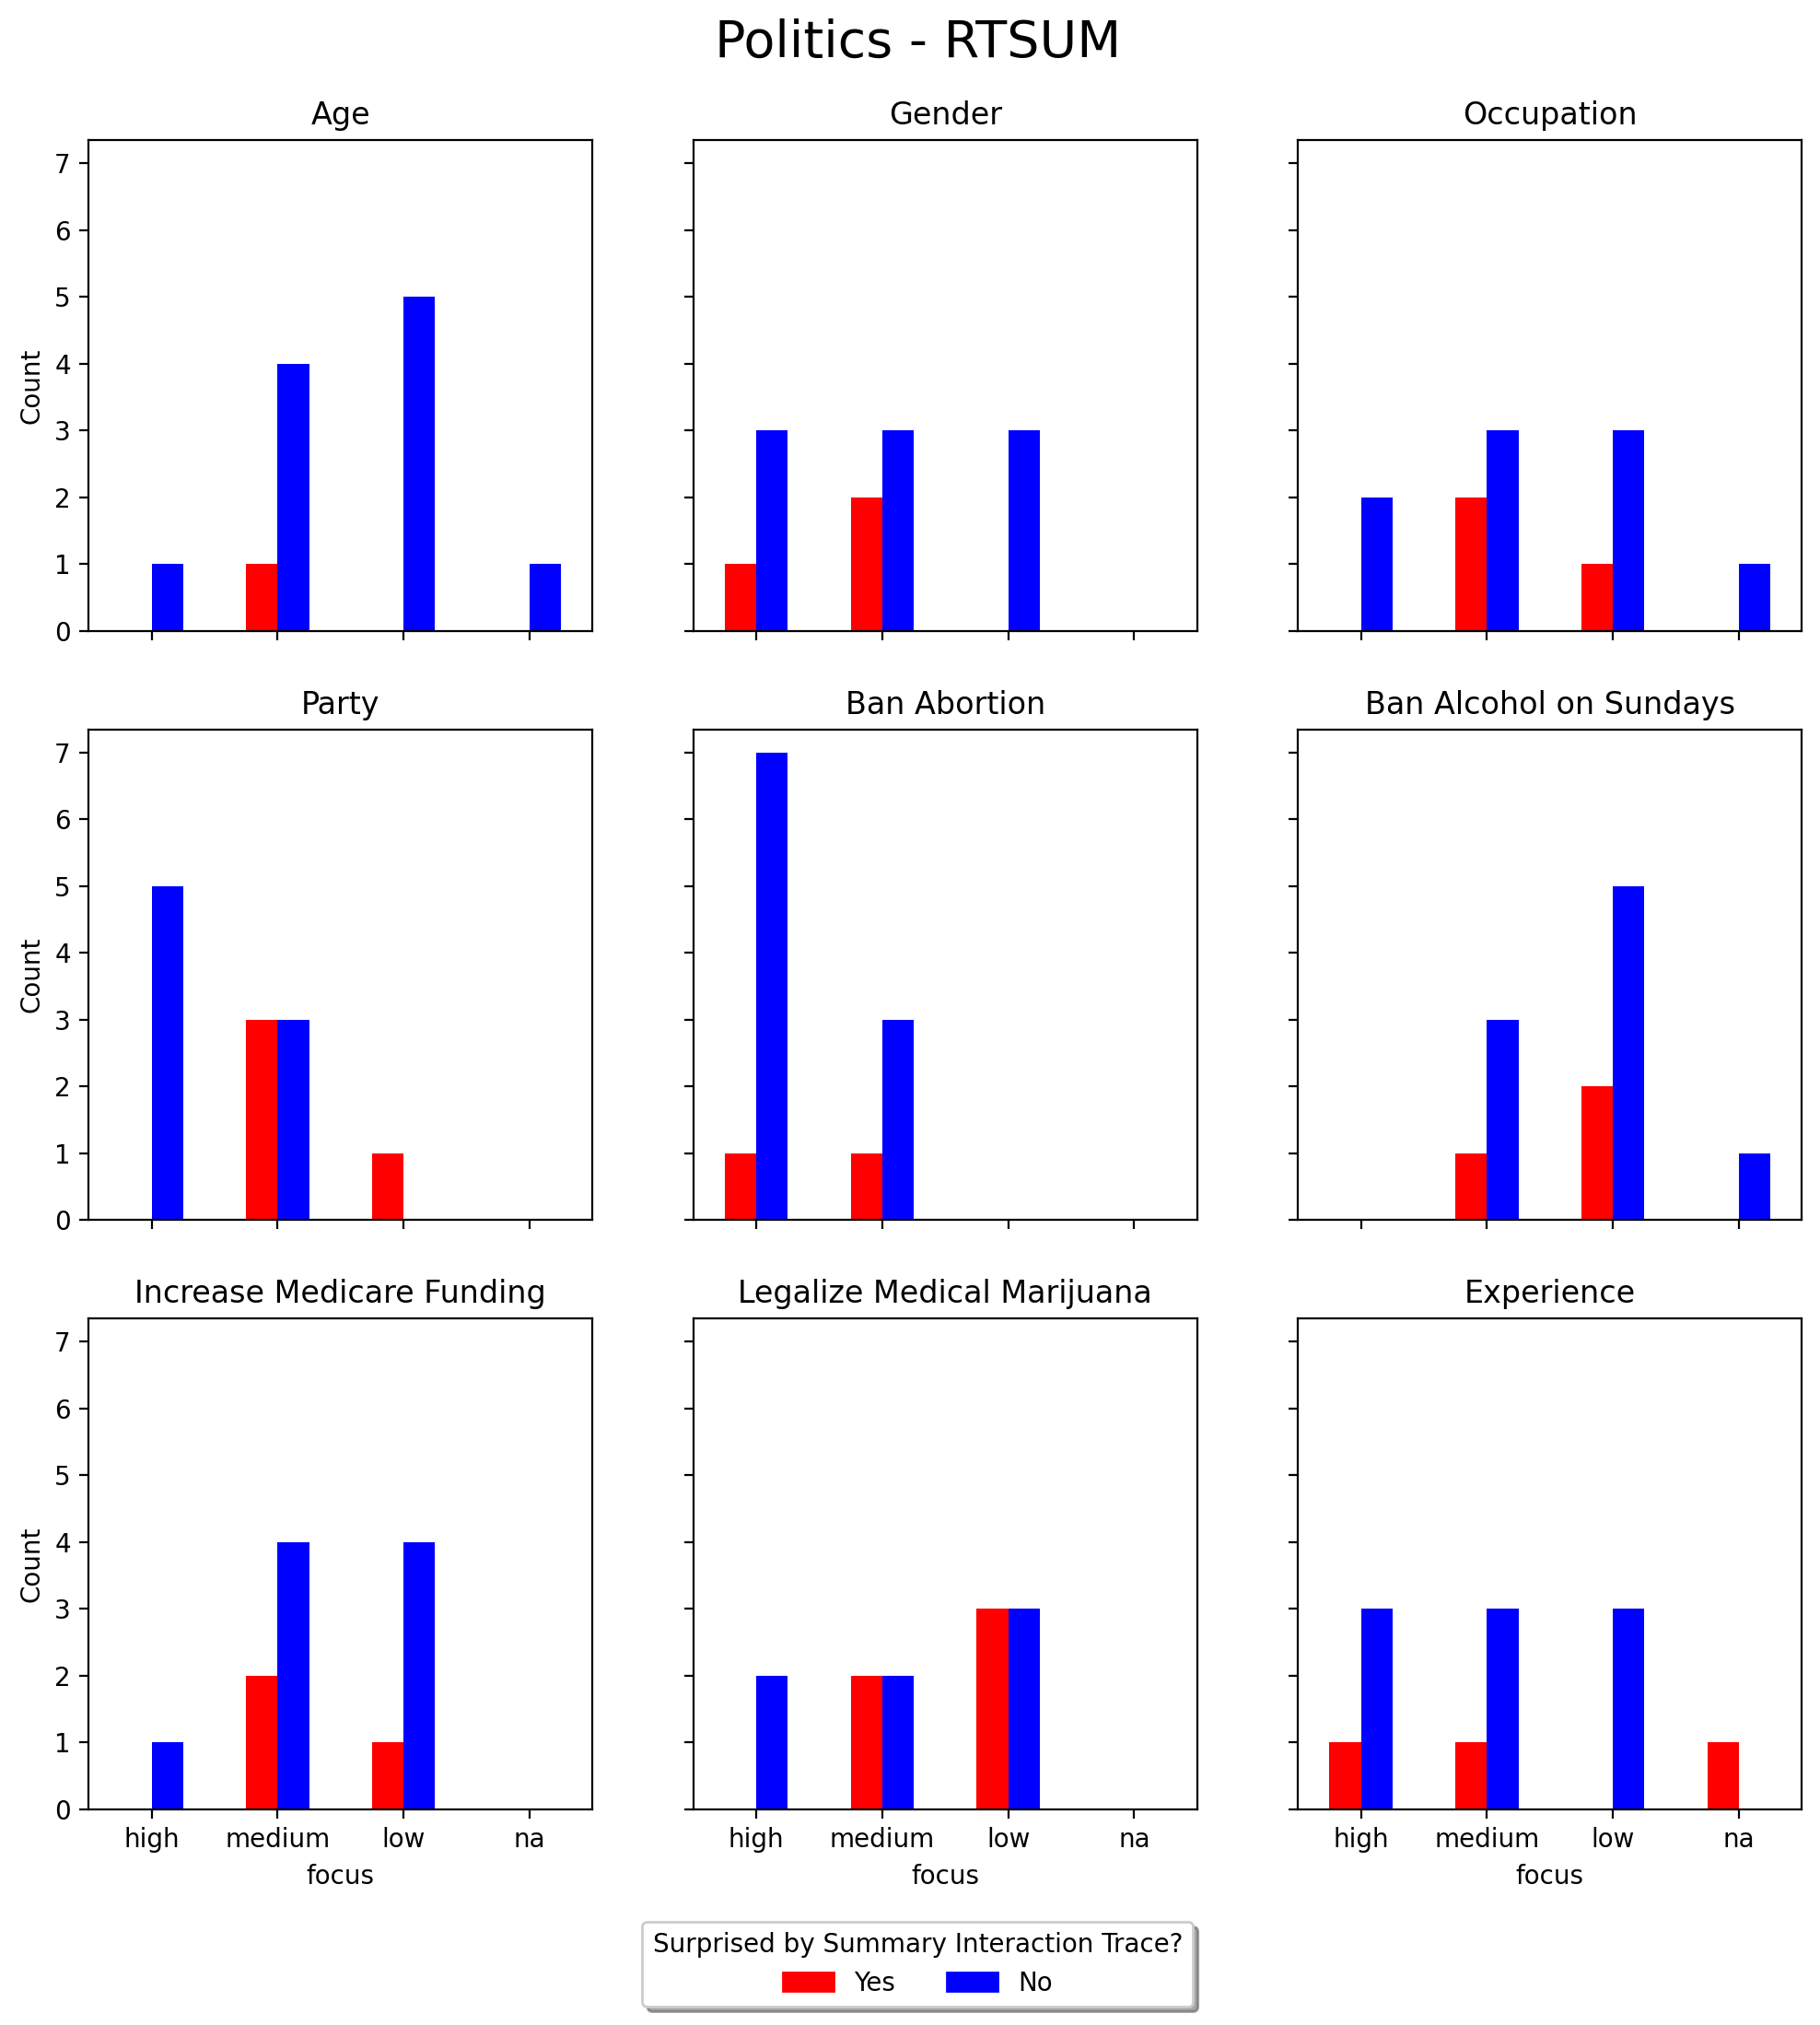

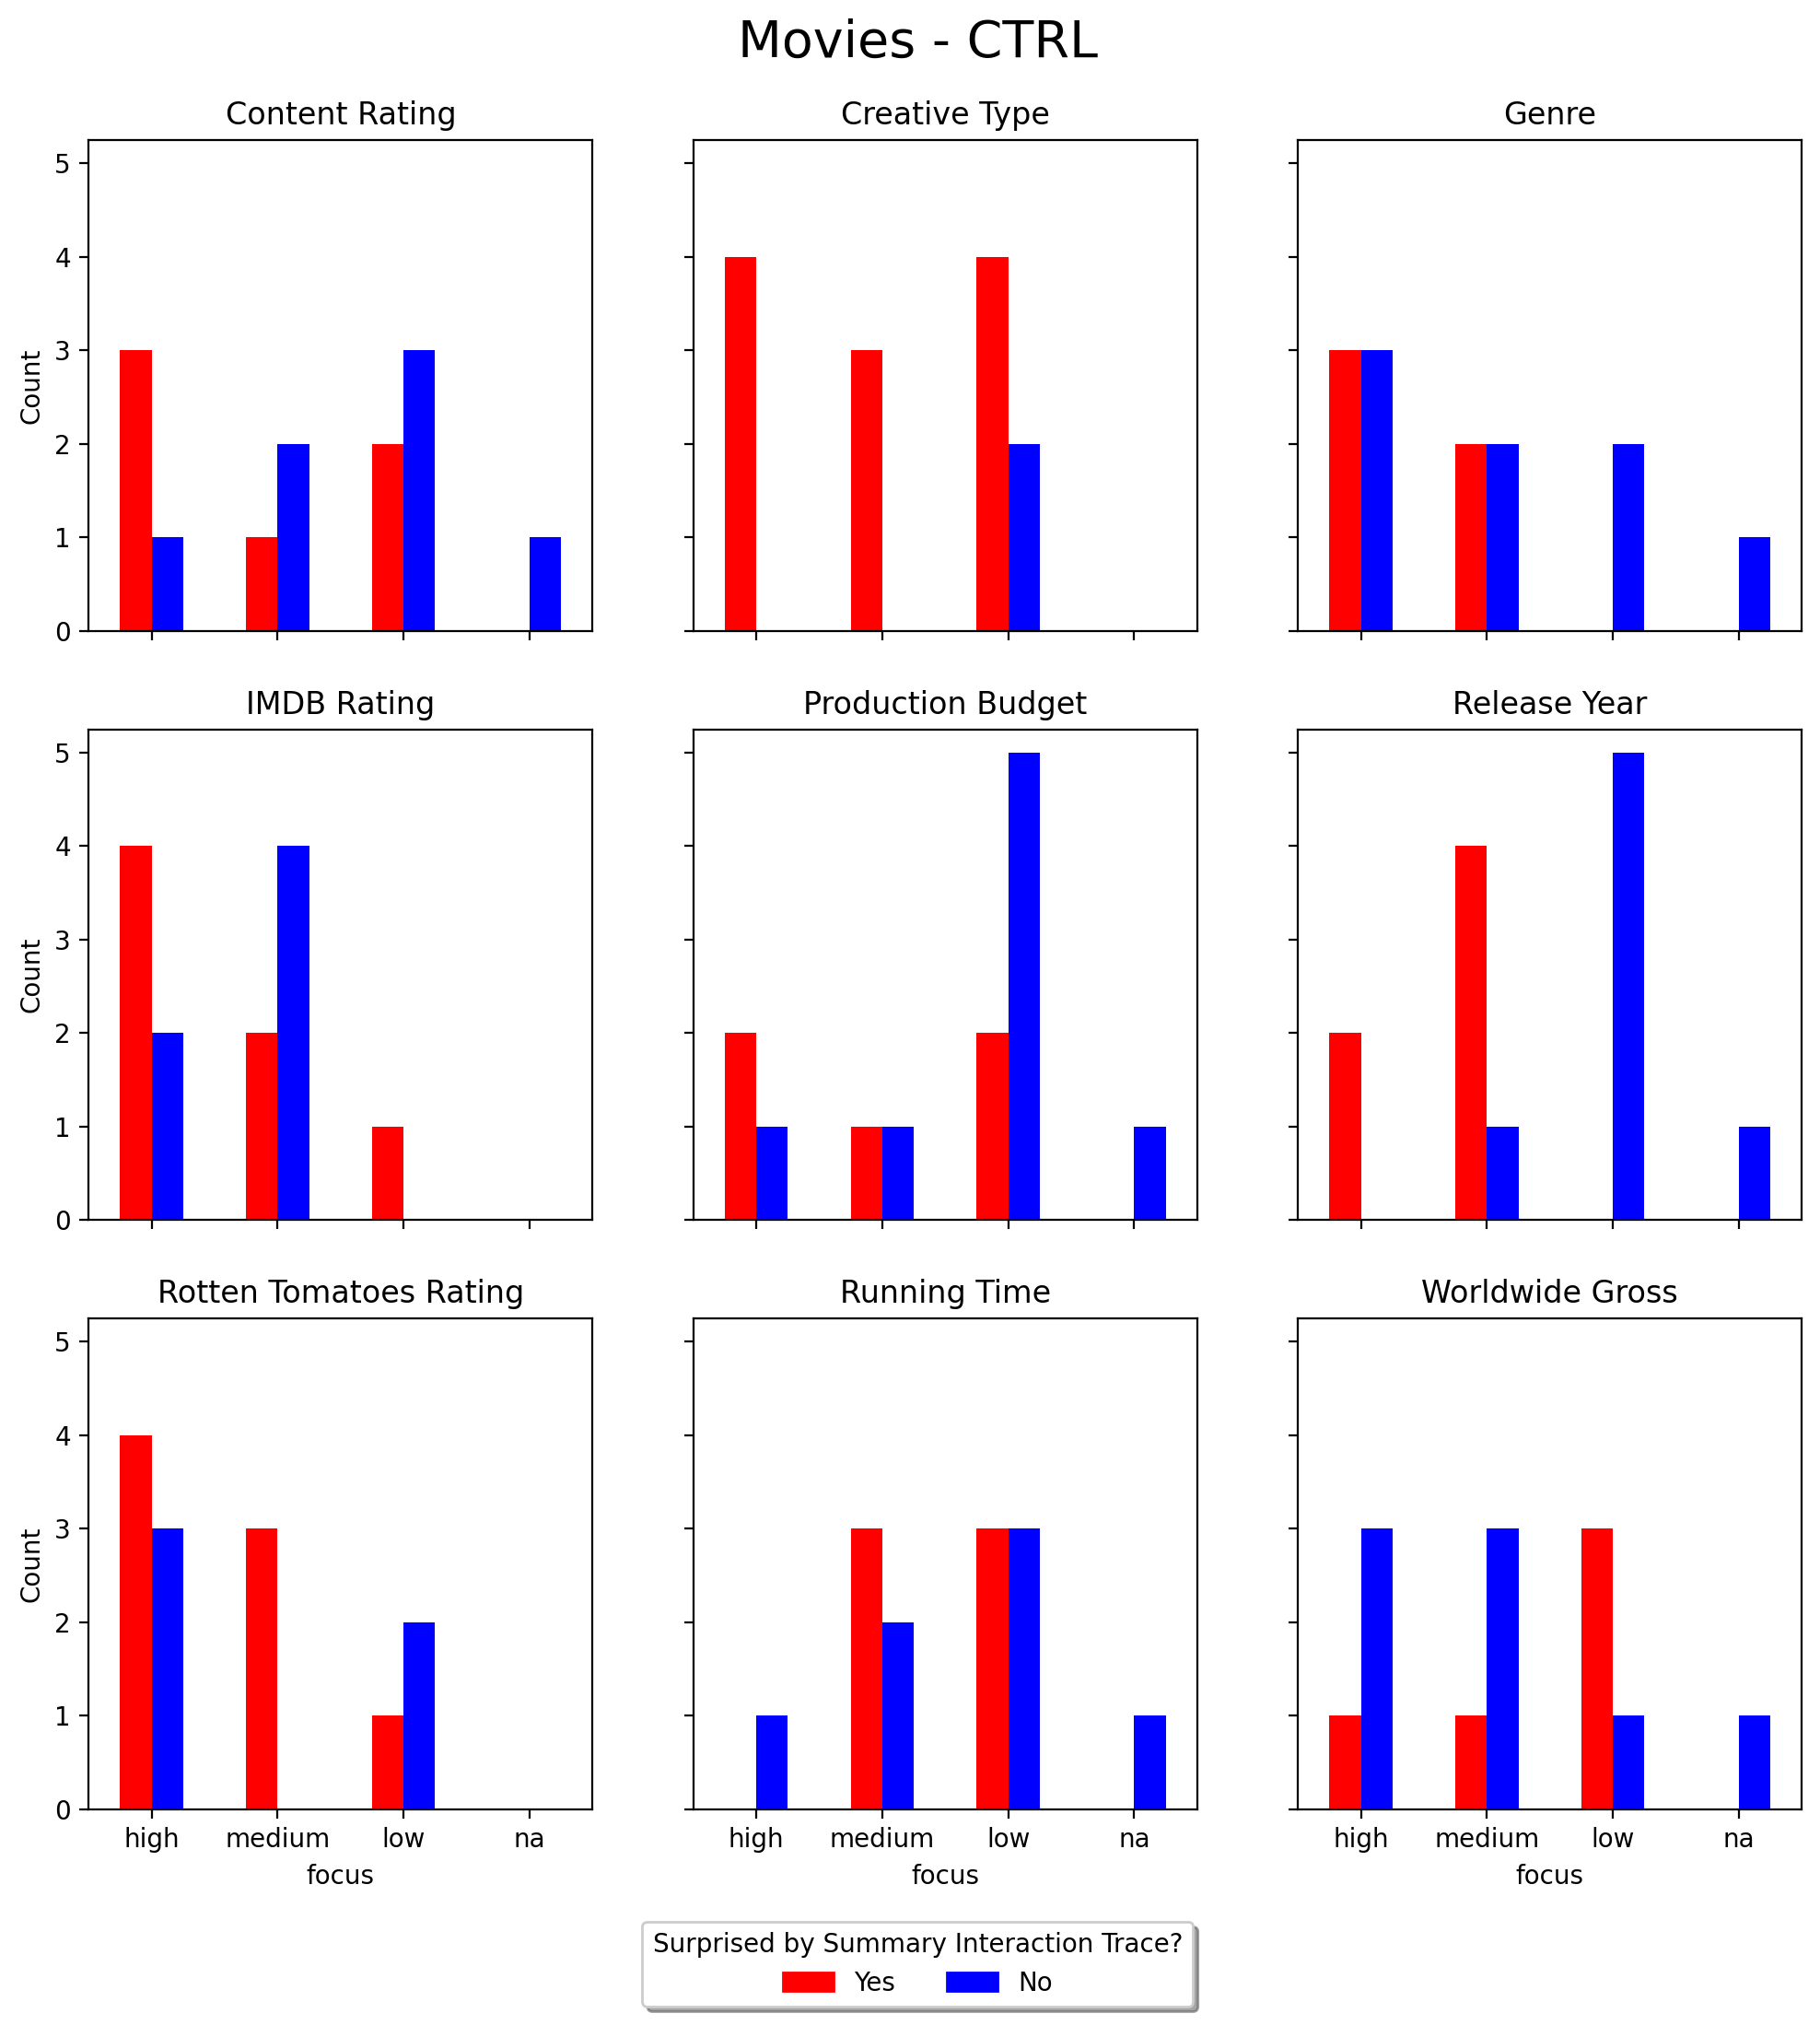

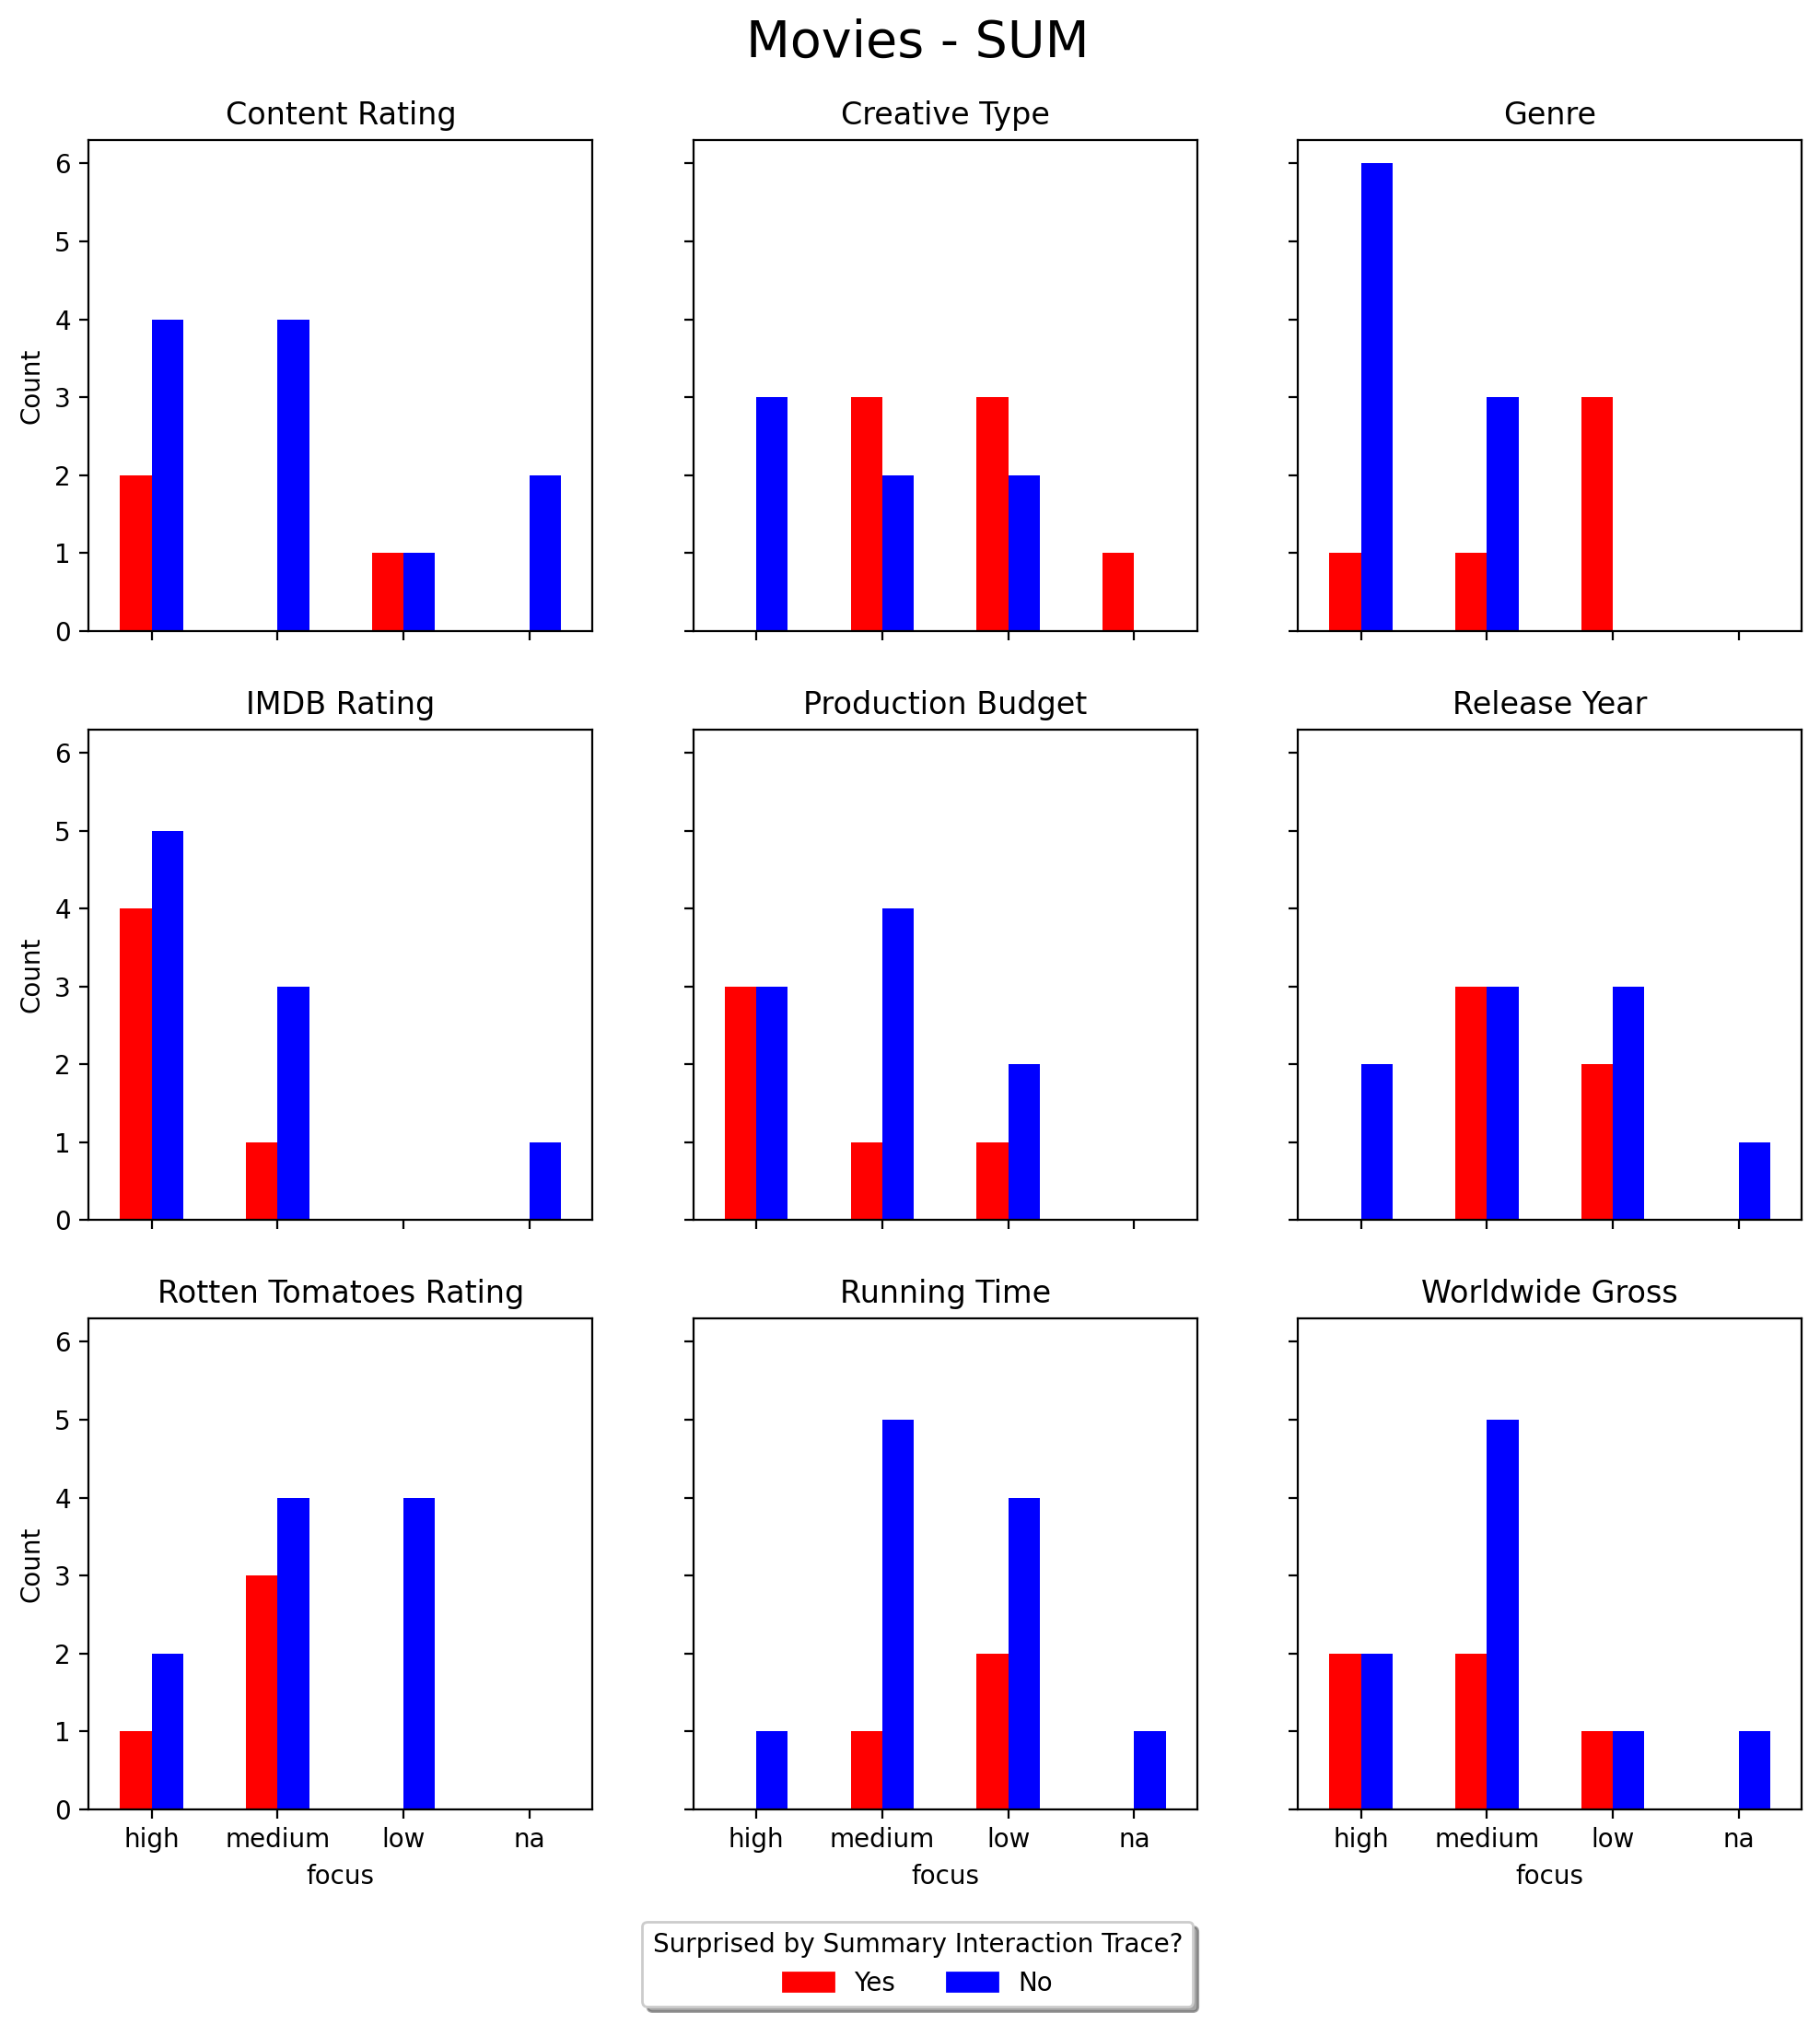

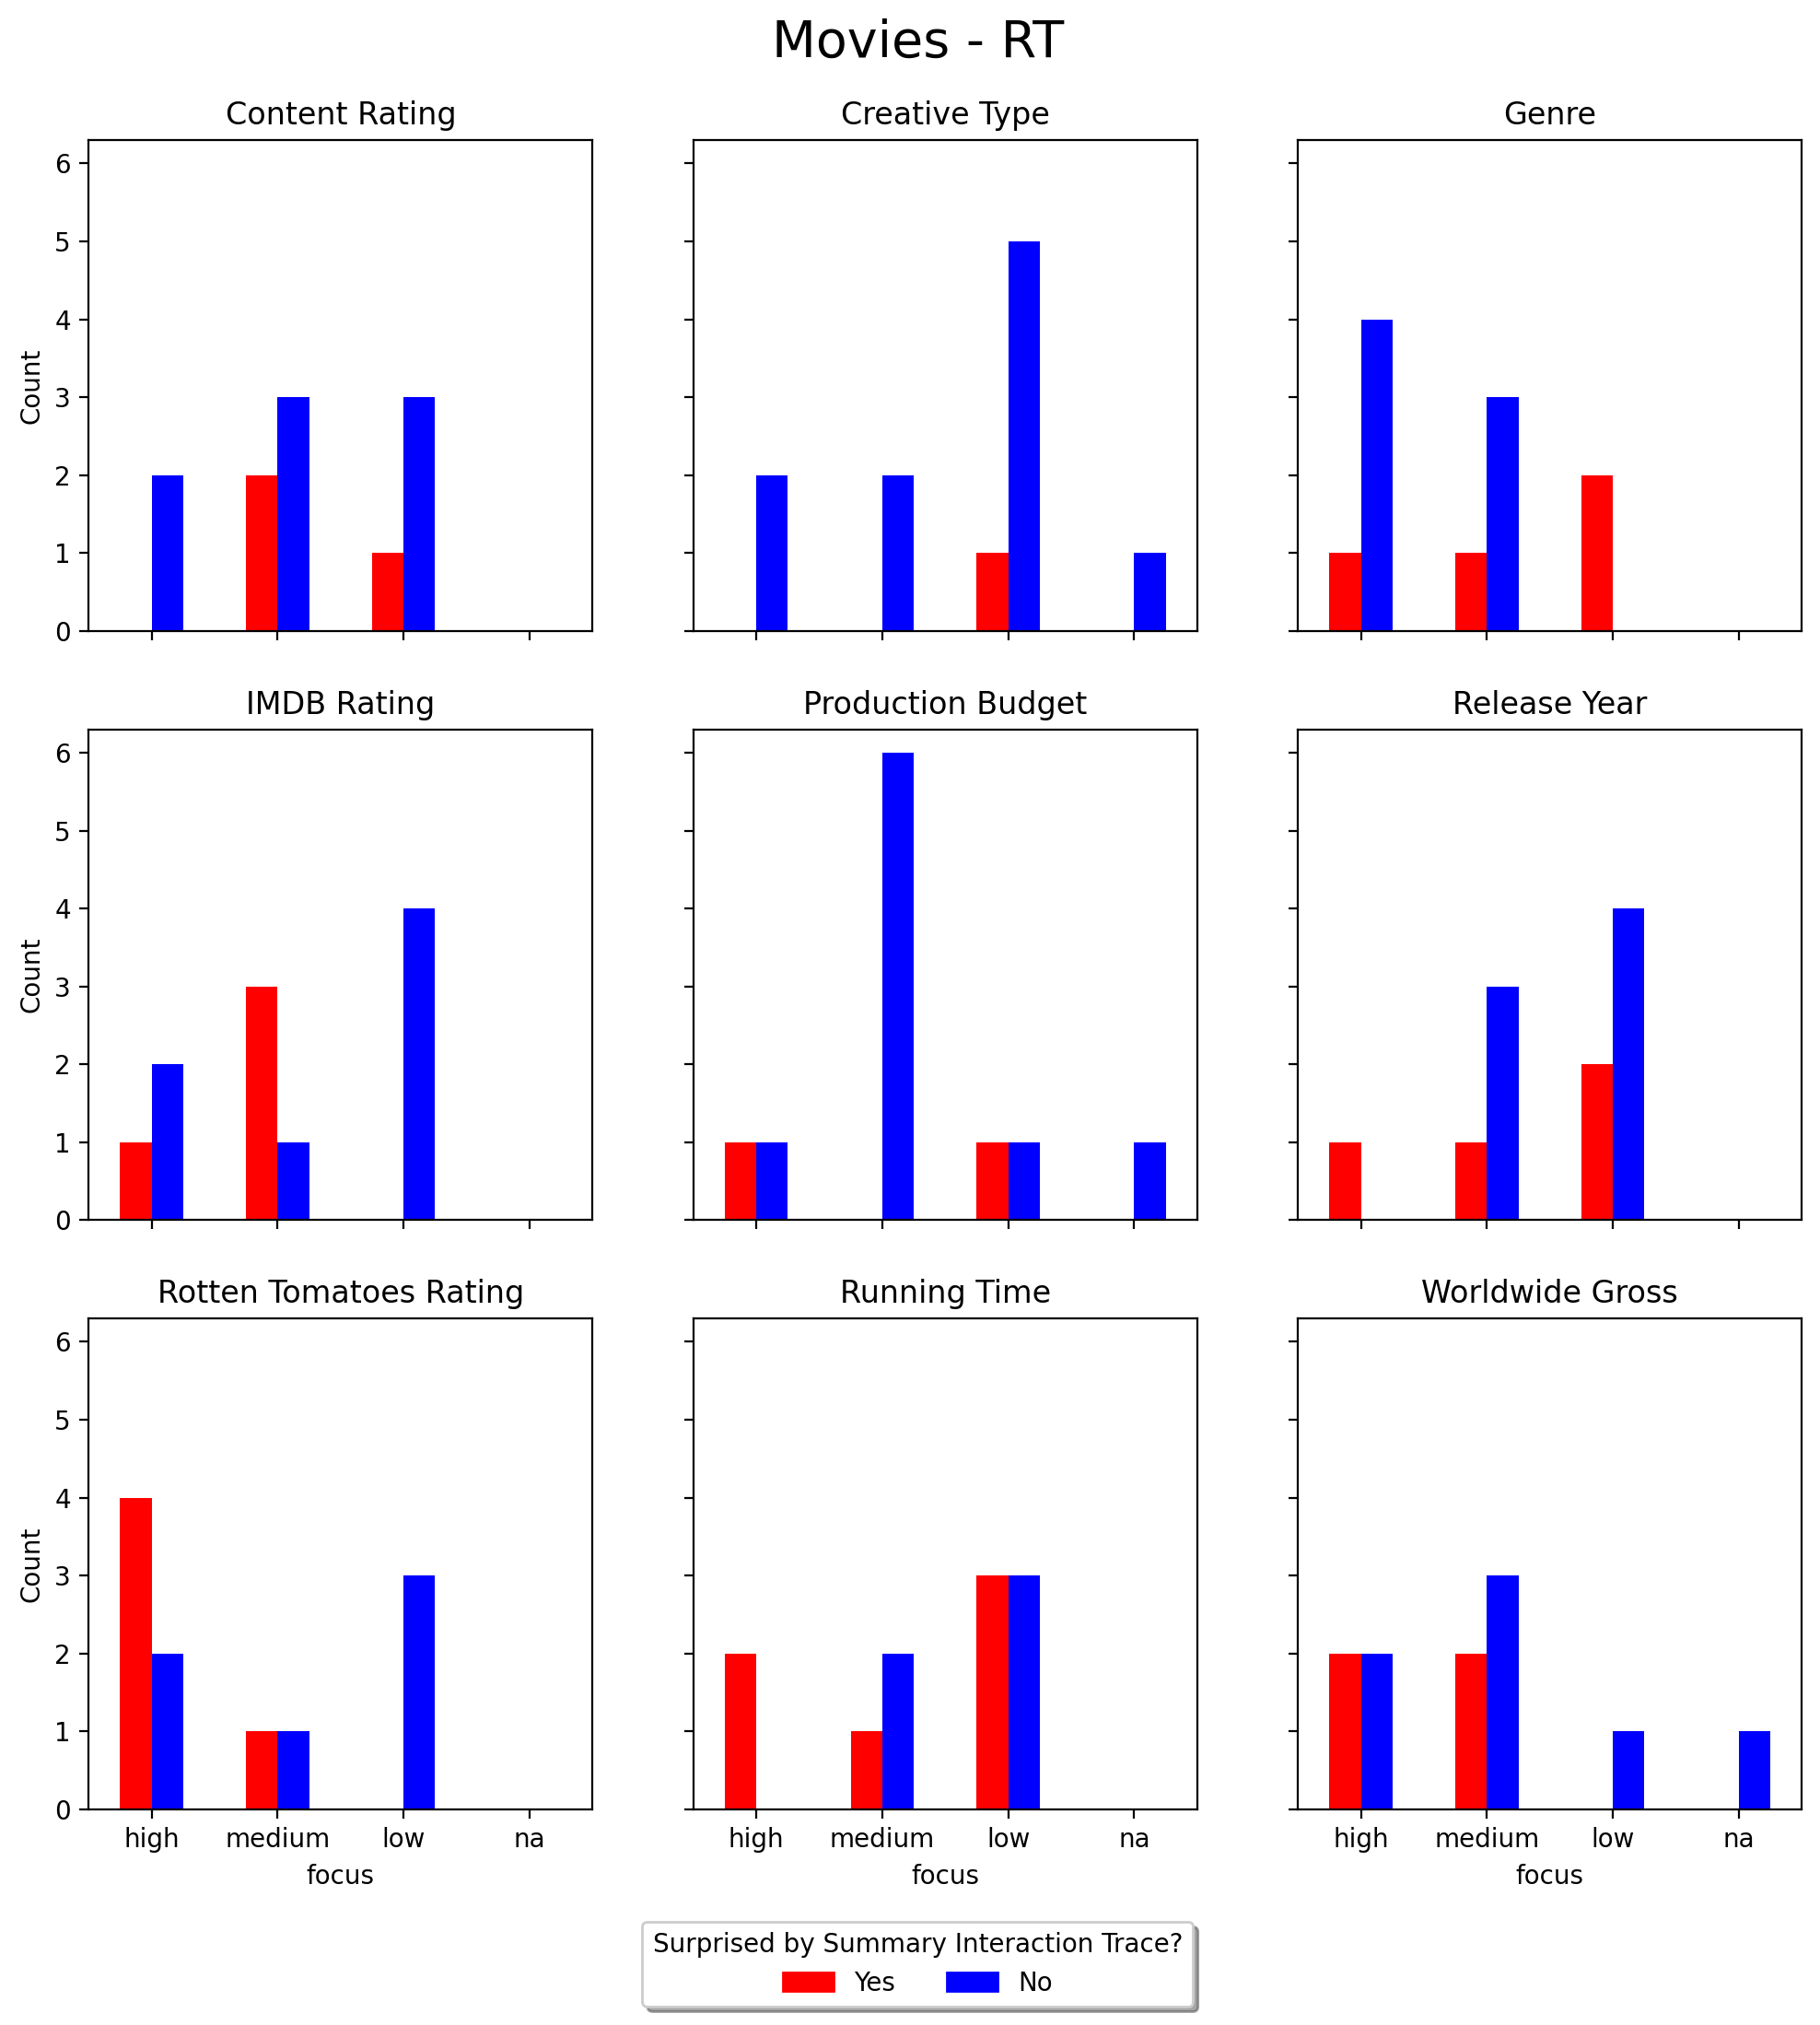

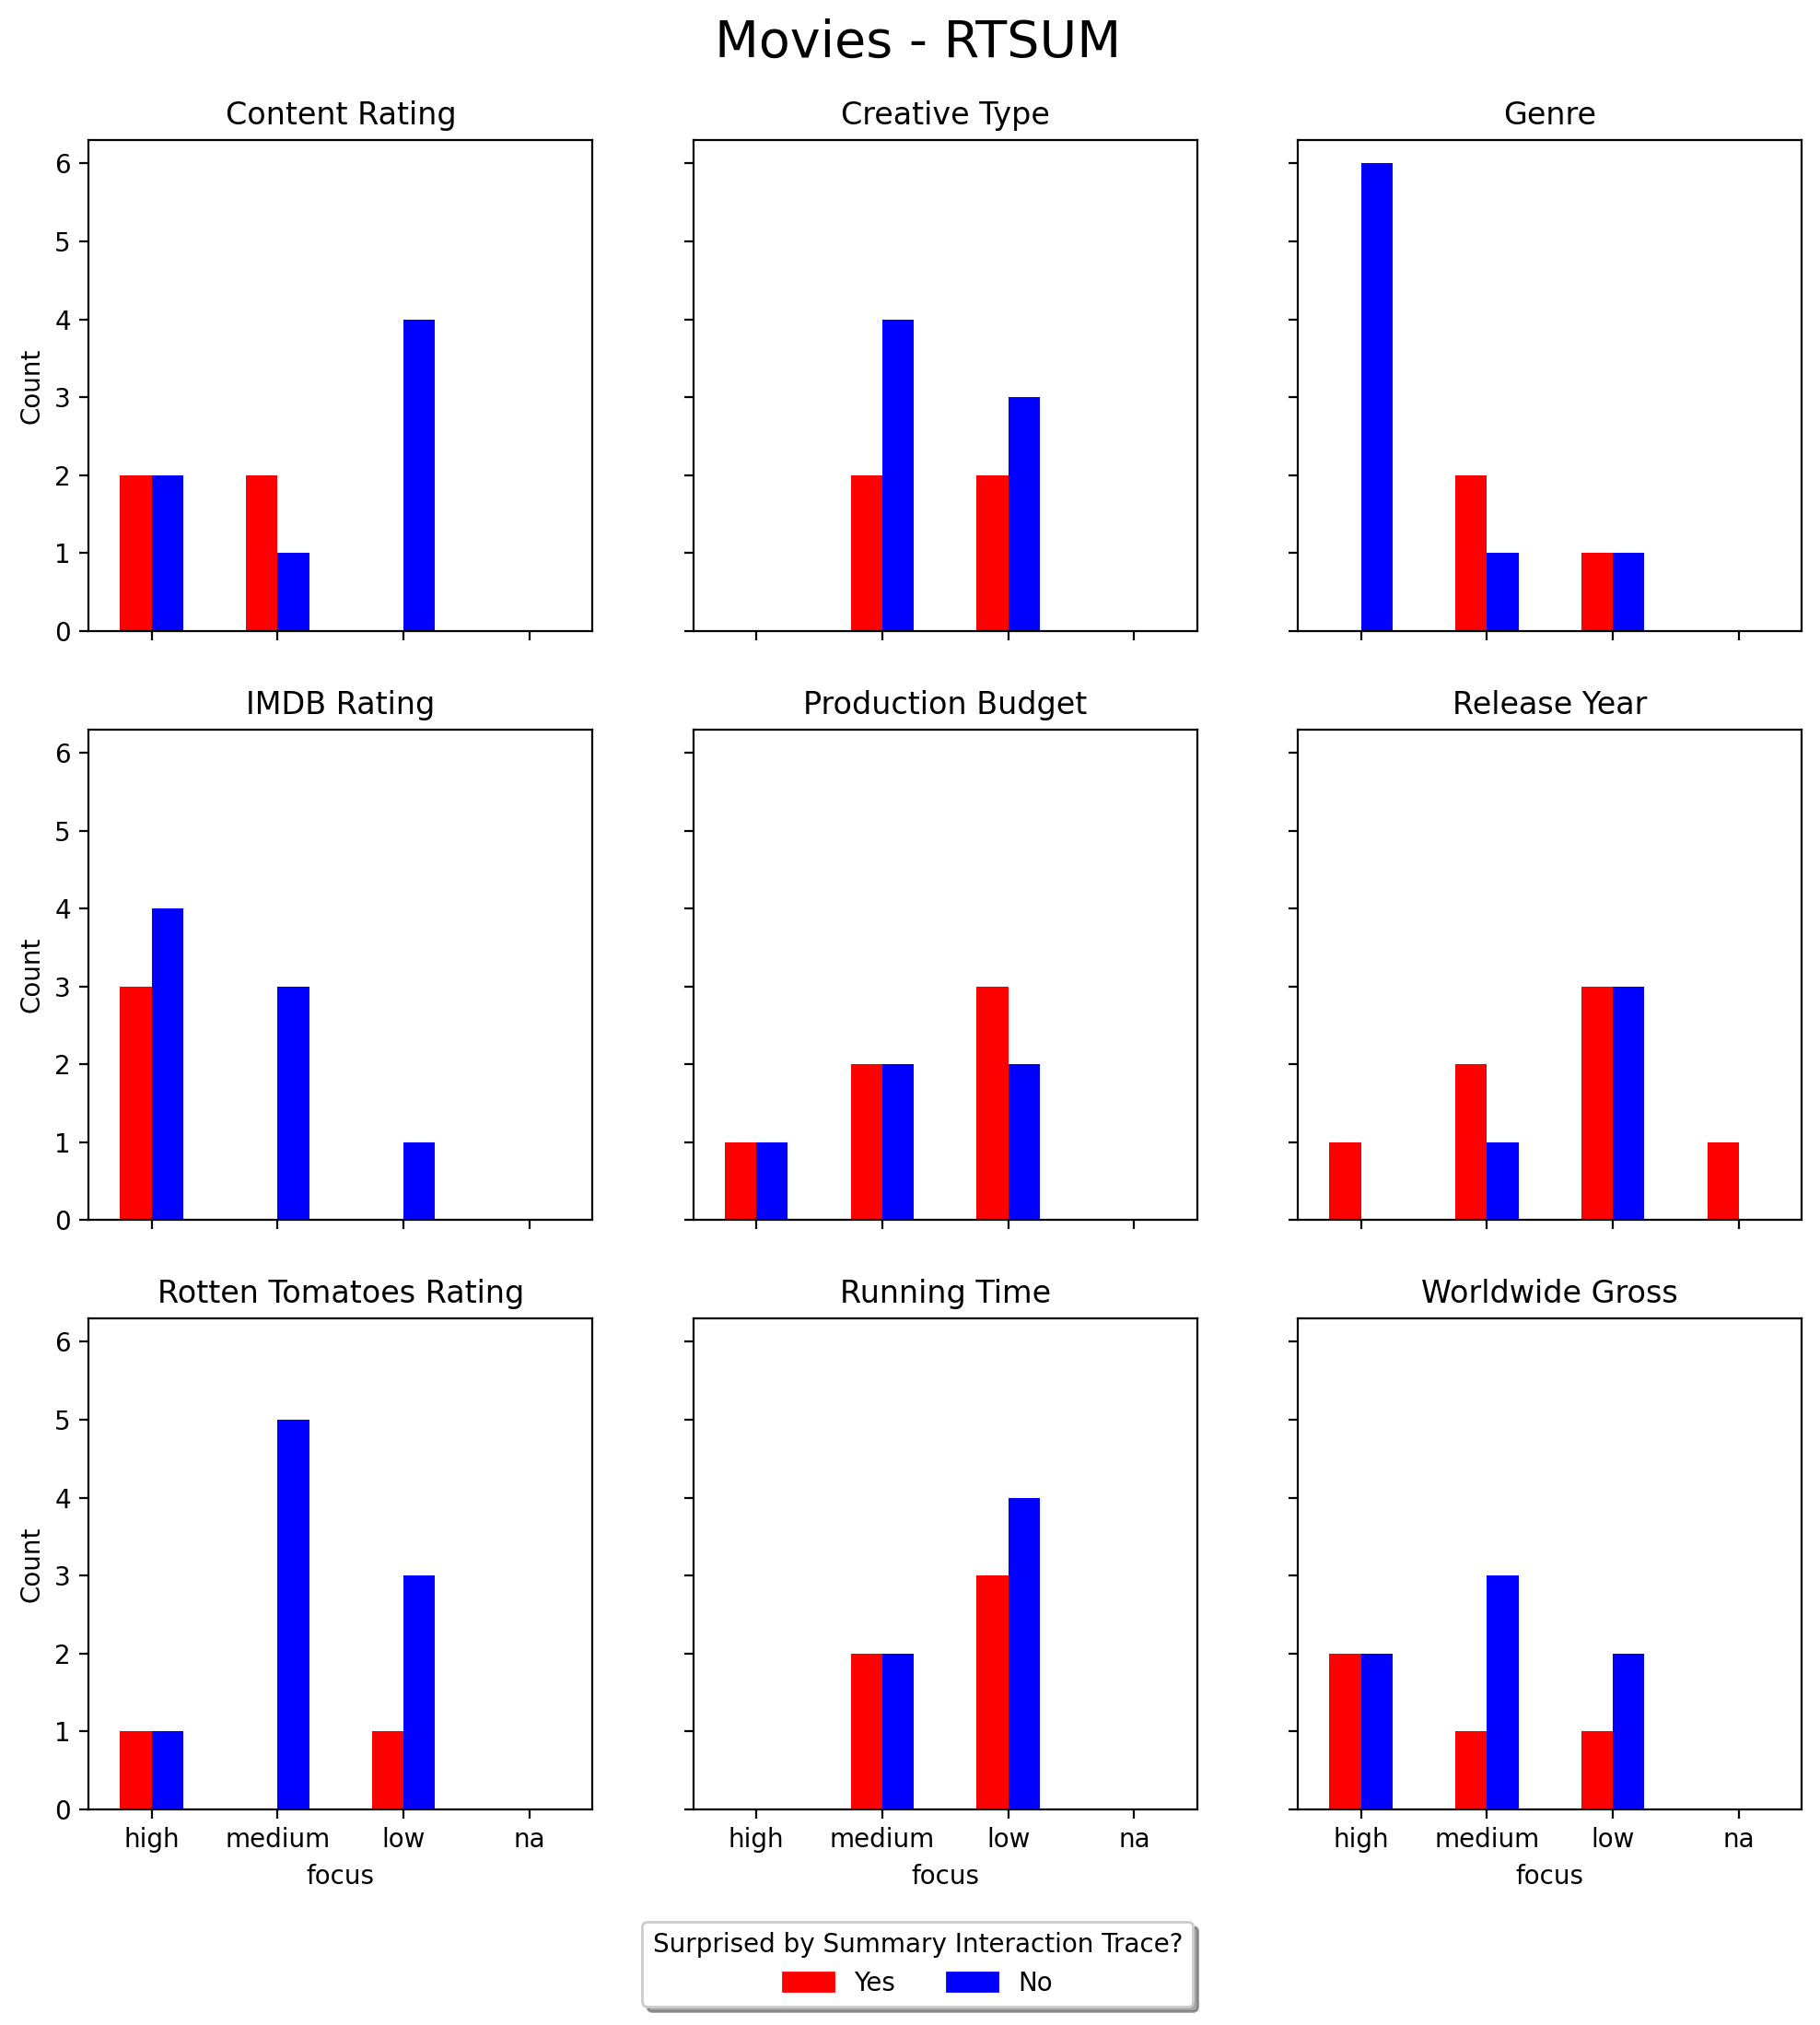

In [4]:
row_index = {
    'politics': 1,
    'movies': 0,
}


for task in ['politics', 'movies']:
    for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
        PIDS = ALL_PIDS[condition]
        
        ### SURPRISE/FOCUS ###

        dfs = []
        for pid in PIDS:
            # get file
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
            if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                # append surprise/focus counts
                dfs.append(
                    df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series).T[row_index[task]]
                        .map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series)
                        .reset_index()
                        .rename(columns={'index': 'attribute'})
                        .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                )

        # push the dataframes together
        surprise_focus = pd.concat(dfs, ignore_index=True)


        ### Surprise/focus by attribute ###

        plot_titles = {
            'politics': {
                'age': 'Age',
                'gender': 'Gender',
                'occupation': 'Occupation',
                'party': 'Party',
                'political_experience': 'Experience',
                'policy_strength_ban_abortion_after_6_weeks': 'Ban Abortion',
                'policy_strength_legalize_medical_marijuana': 'Legalize Medical Marijuana',
                'policy_strength_increase_medicare_funding': 'Increase Medicare Funding',
                'policy_strength_ban_alcohol_sales_sundays': 'Ban Alcohol on Sundays'
            },
            'movies': {
                "Running Time": "Running Time",
                "Production Budget": "Production Budget",
                "Worldwide Gross": "Worldwide Gross",
                "Rotten Tomatoes Rating": "Rotten Tomatoes Rating",
                "IMDB Rating": "IMDB Rating",
                "Genre": "Genre",
                "Creative Type": "Creative Type",
                "Content Rating": "Content Rating",
                "Release Year": "Release Year",
            }
        }

        total_rows = 3
        total_cols = 3
        fig, ax = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(12,12))
        plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

        countrow = 0
        countcol = 0
        for key, grp in surprise_focus.groupby(['attribute']):
            ax_curr = ax[countrow][countcol]
            ax_curr.set_ylabel('Count')
            (
                grp.groupby(['focus', 'surprise'])
                    .size()
                    .unstack(fill_value=0)
                    .reindex(["high", "medium", "low", "na"])[['yes', 'no']]
                    .plot.bar(ax=ax_curr, colors=['r', 'b'], title=plot_titles[task][key], legend=None)
            )
            ax_curr.tick_params(axis='x', rotation=0)
            countcol += 1
            if (countcol == total_cols):
                countcol = 0
                countrow += 1
                if (countrow == total_rows):
                    break

        yes_patch = patches.Patch(color='r')
        no_patch = patches.Patch(color='b')
        handles = [yes_patch, no_patch]
        labels = ['Yes', 'No']
        fig.legend(handles, labels, title="Surprised by Summary Interaction Trace?", loc='upper center', 
                   bbox_to_anchor=(0.5, 0.08), fancybox=True, shadow=True, ncol=2)
        
        fig.suptitle(f'{task.capitalize()} - {condition.upper()}', x=0.5, y=0.935, fontsize=20)

#         plt.savefig(f'charts/surprise/{task}/{condition}_{task}_focus_surprise_across_attributes.png', dpi=300, bbox_inches='tight')
#         plt.close(fig)

# Total Attribute Surprise Counts Grouped by Focus - For Each Condition - For Each Task

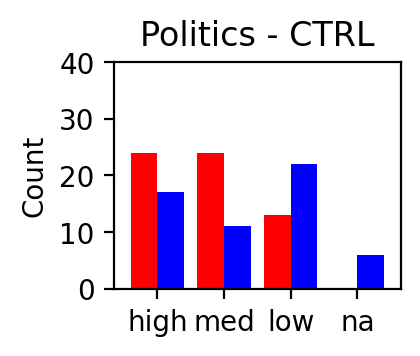

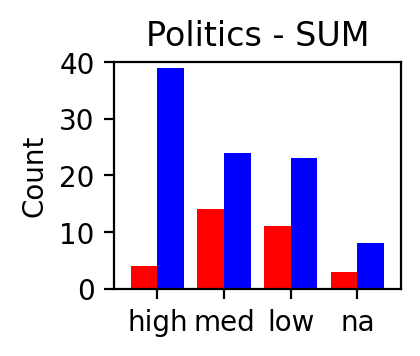

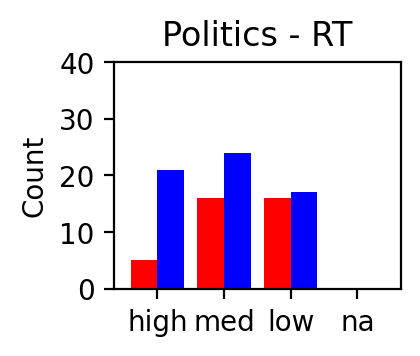

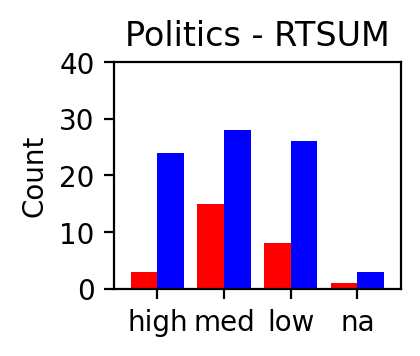

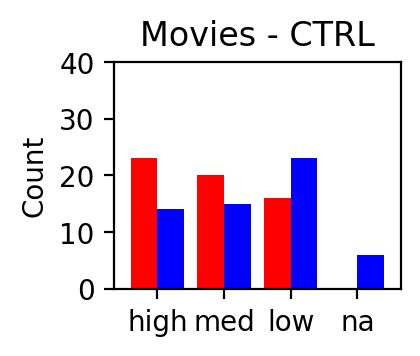

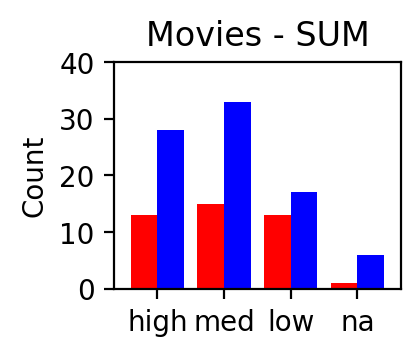

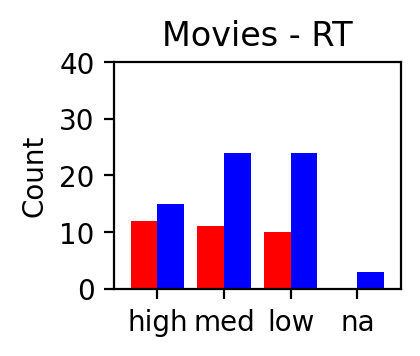

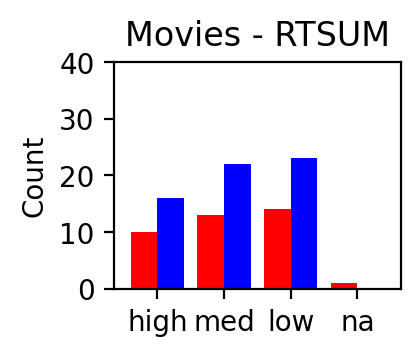

In [9]:
row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
        dfs = []
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            # get file
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
            if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                # append surprise/focus counts
                dfs.append(
                    df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series).T[row_index[task]]
                        .map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series)
                        .reset_index()
                        .rename(columns={'index': 'attribute'})
                        .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                )

        # push the dataframes together
        surprise_focus = pd.concat(dfs, ignore_index=True).replace('medium', 'med')

        ### Total surprise/focus ###
        fig, ax = plt.subplots(1, 1, figsize=(1.85,1.5))
        (
            surprise_focus.groupby(['focus', 'surprise'])
                .size()
                .unstack(fill_value=0)
                .reindex(["high", "med", "low", "na"])[['yes', 'no']]
                .plot.bar(ax=ax, colors=['r', 'b'], width=0.8, legend=None)
        )
        ax.set_ylim([0, 40])  # standardize y-axis across task charts
        ax.set_ylabel('Count')
        ax.set_xlabel('')
        ax.set_title(f'{task.capitalize()} - {condition.upper()}')
        ax.tick_params(axis='x', rotation=0)

#         plt.savefig(f'charts/surprise/{task}/{condition}_{task}_focus_surprise_total.png', dpi=300, bbox_inches='tight')
#         plt.close(fig)

# Total Attribute Surprise Counts Grouped by Focus - For Each Task

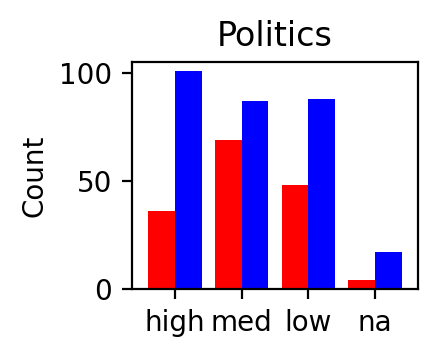

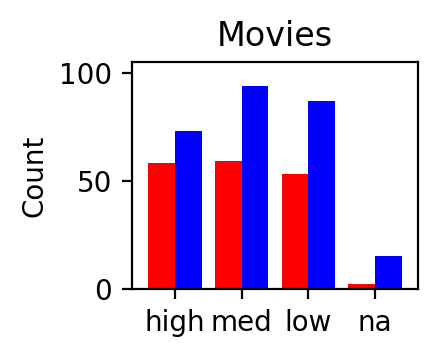

In [6]:
row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    dfs = []
    for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            # get file
            basepath = os.path.join(condition, pid)  # basepath for PID
            try:
                df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                appOrder = "PM"
            except FileNotFoundError:
                df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                appOrder = "MP"

            # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
            if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                # append surprise/focus counts
                dfs.append(
                    df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series).T[row_index[task]]
                        .map(lambda x: ast.literal_eval(str(x)))
                        .apply(pd.Series)
                        .reset_index()
                        .rename(columns={'index': 'attribute'})
                        .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                )

    # push the dataframes together
    surprise_focus = pd.concat(dfs, ignore_index=True).replace('medium', 'med')


    ### Total surprise/focus ###
    fig, ax = plt.subplots(1, 1, figsize=(1.85,1.5))
    (
        surprise_focus.groupby(['focus', 'surprise'])
            .size()
            .unstack(fill_value=0)
            .reindex(["high", "med", "low", "na"])[['yes', 'no']]
            .plot.bar(ax=ax, colors=['r', 'b'], width=0.8, legend=None)
    )
    ax.set_ylim([0, 105])  # standarize y-axis across tasks
    ax.set_ylabel('Count')
    ax.set_xlabel('')
    ax.set_title(f'{task.capitalize()}')
    ax.tick_params(axis='x', rotation=0)
    
#     handles, labels = ax.get_legend_handles_labels()    
#     plt.legend(handles, labels, title='Surprise', loc='upper center', 
#                bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=1)
    
#     plt.savefig(f'charts/surprise/{task}/{task}_focus_surprise_total.png', dpi=300, bbox_inches='tight')

# ANOVA - Average Attribute AD Metric - Grouped by Focus/Surprise - Across All Conditions

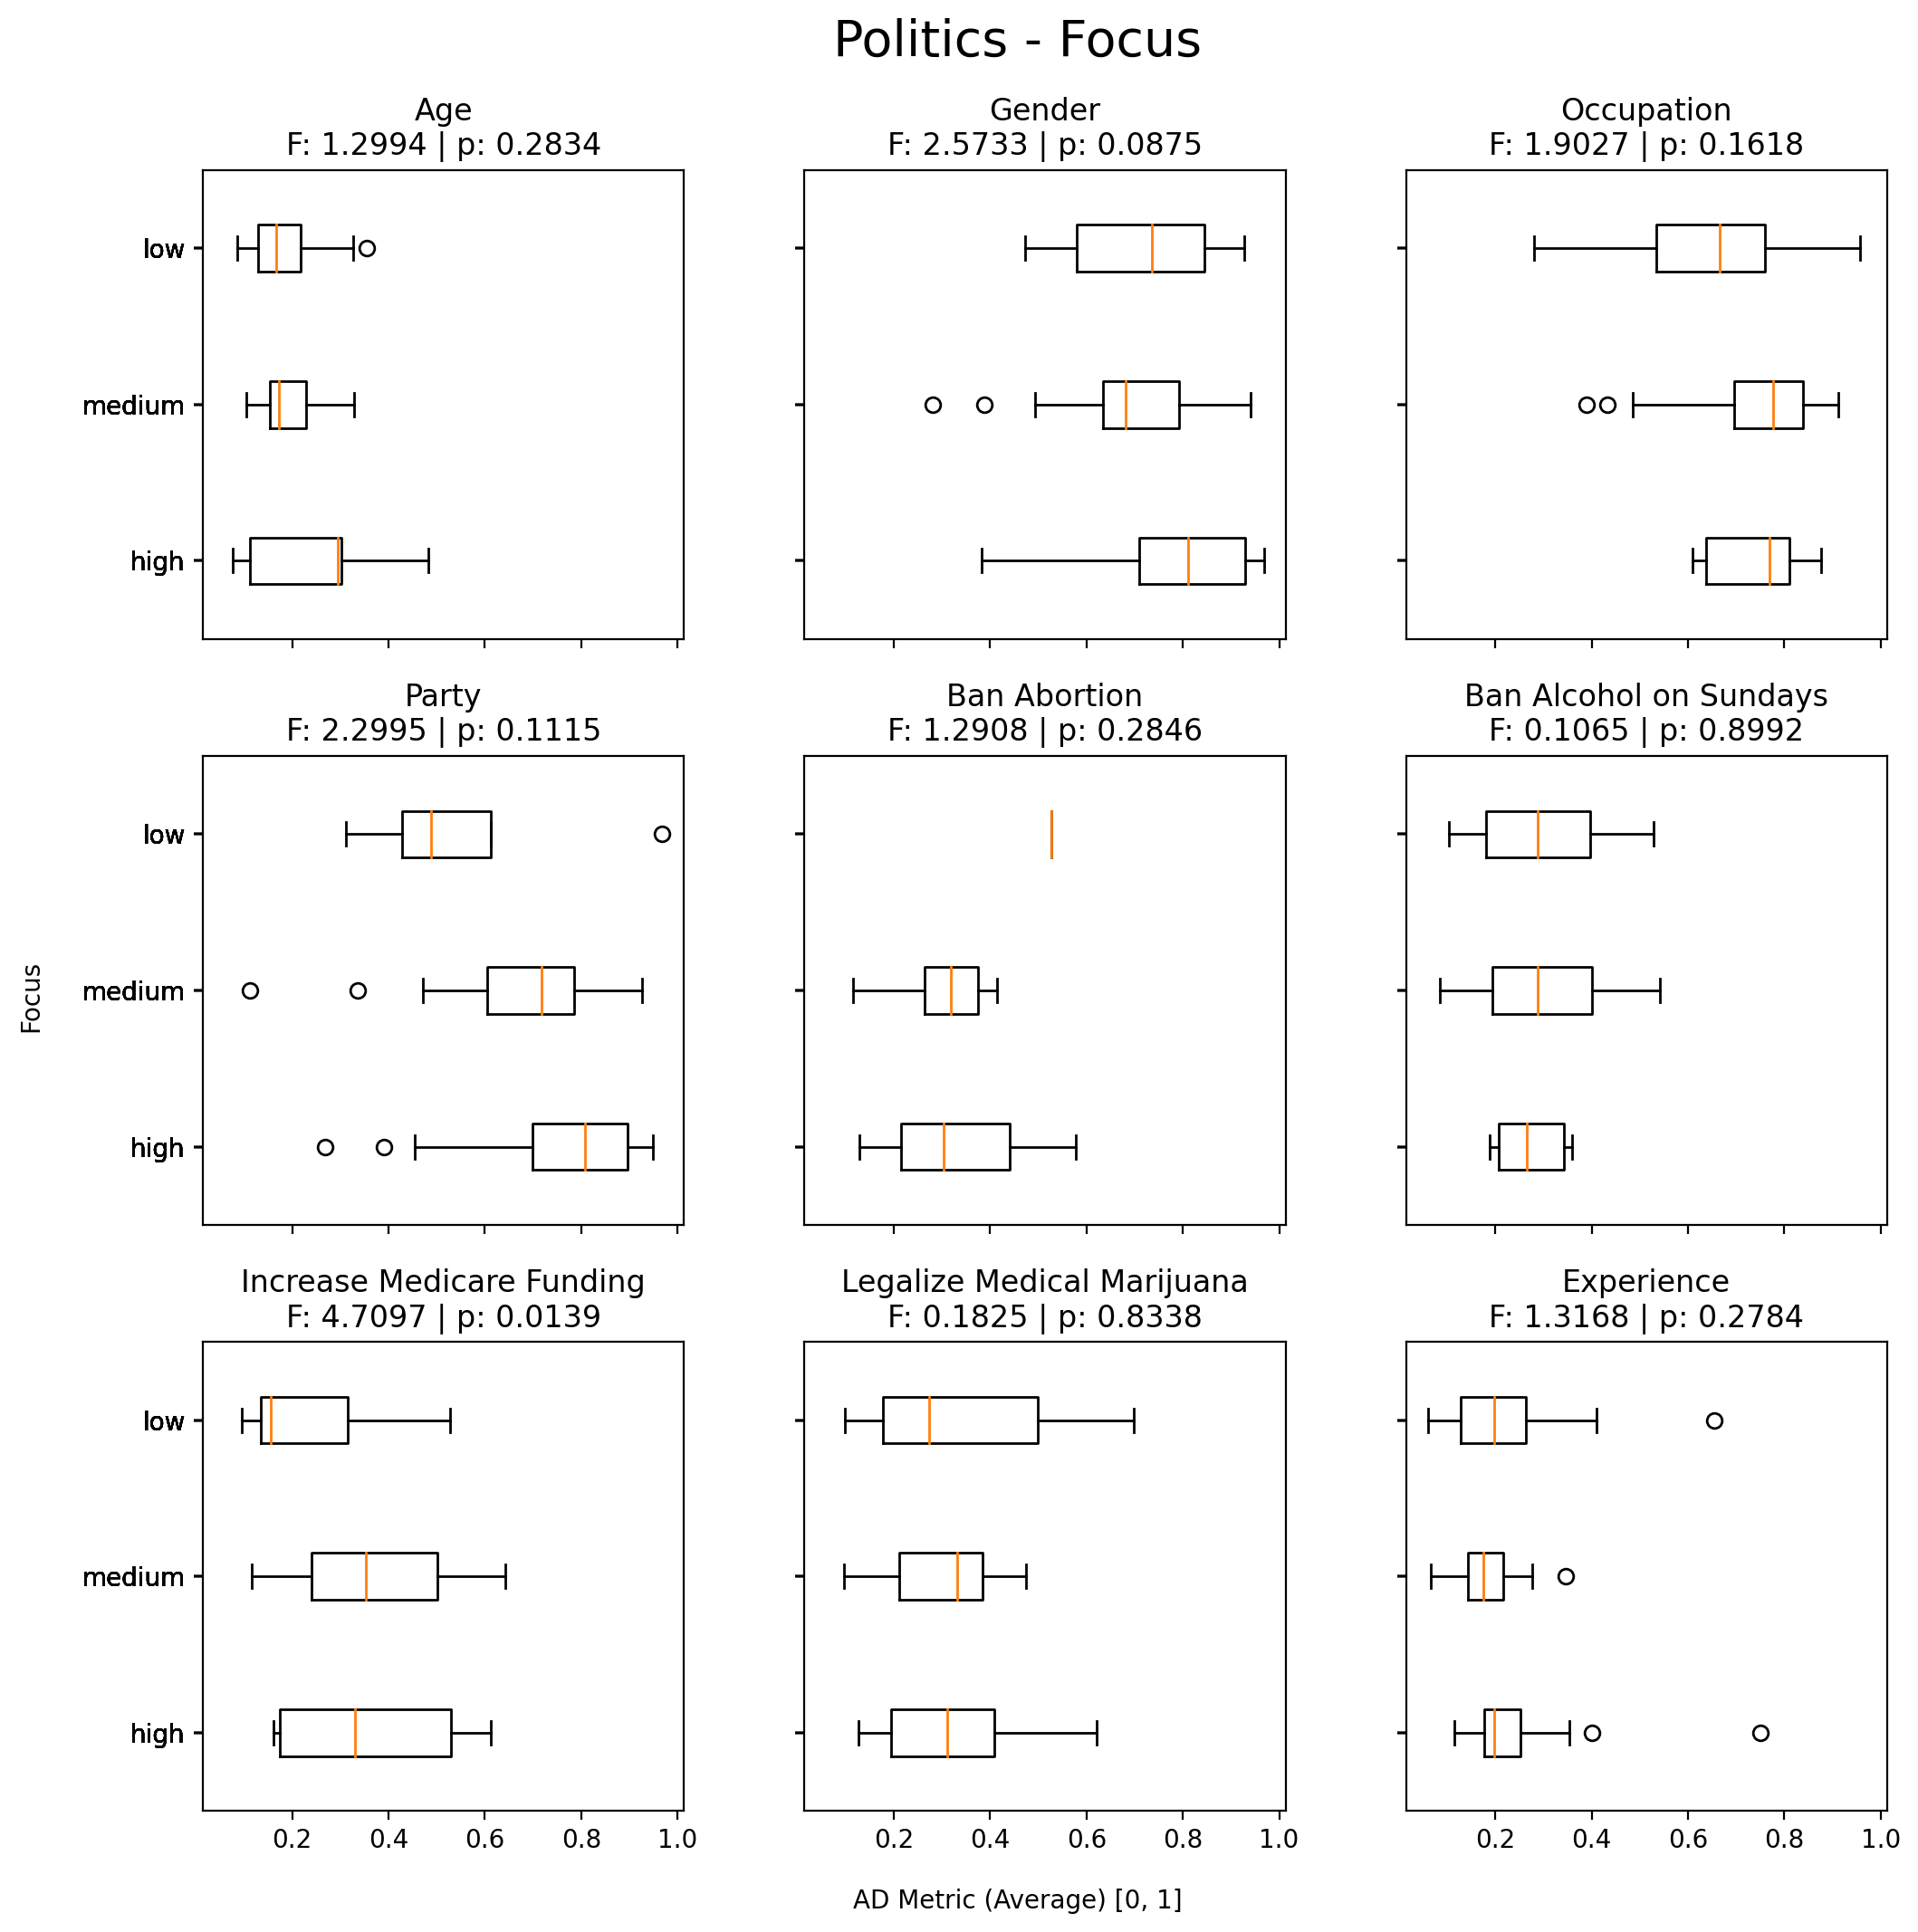

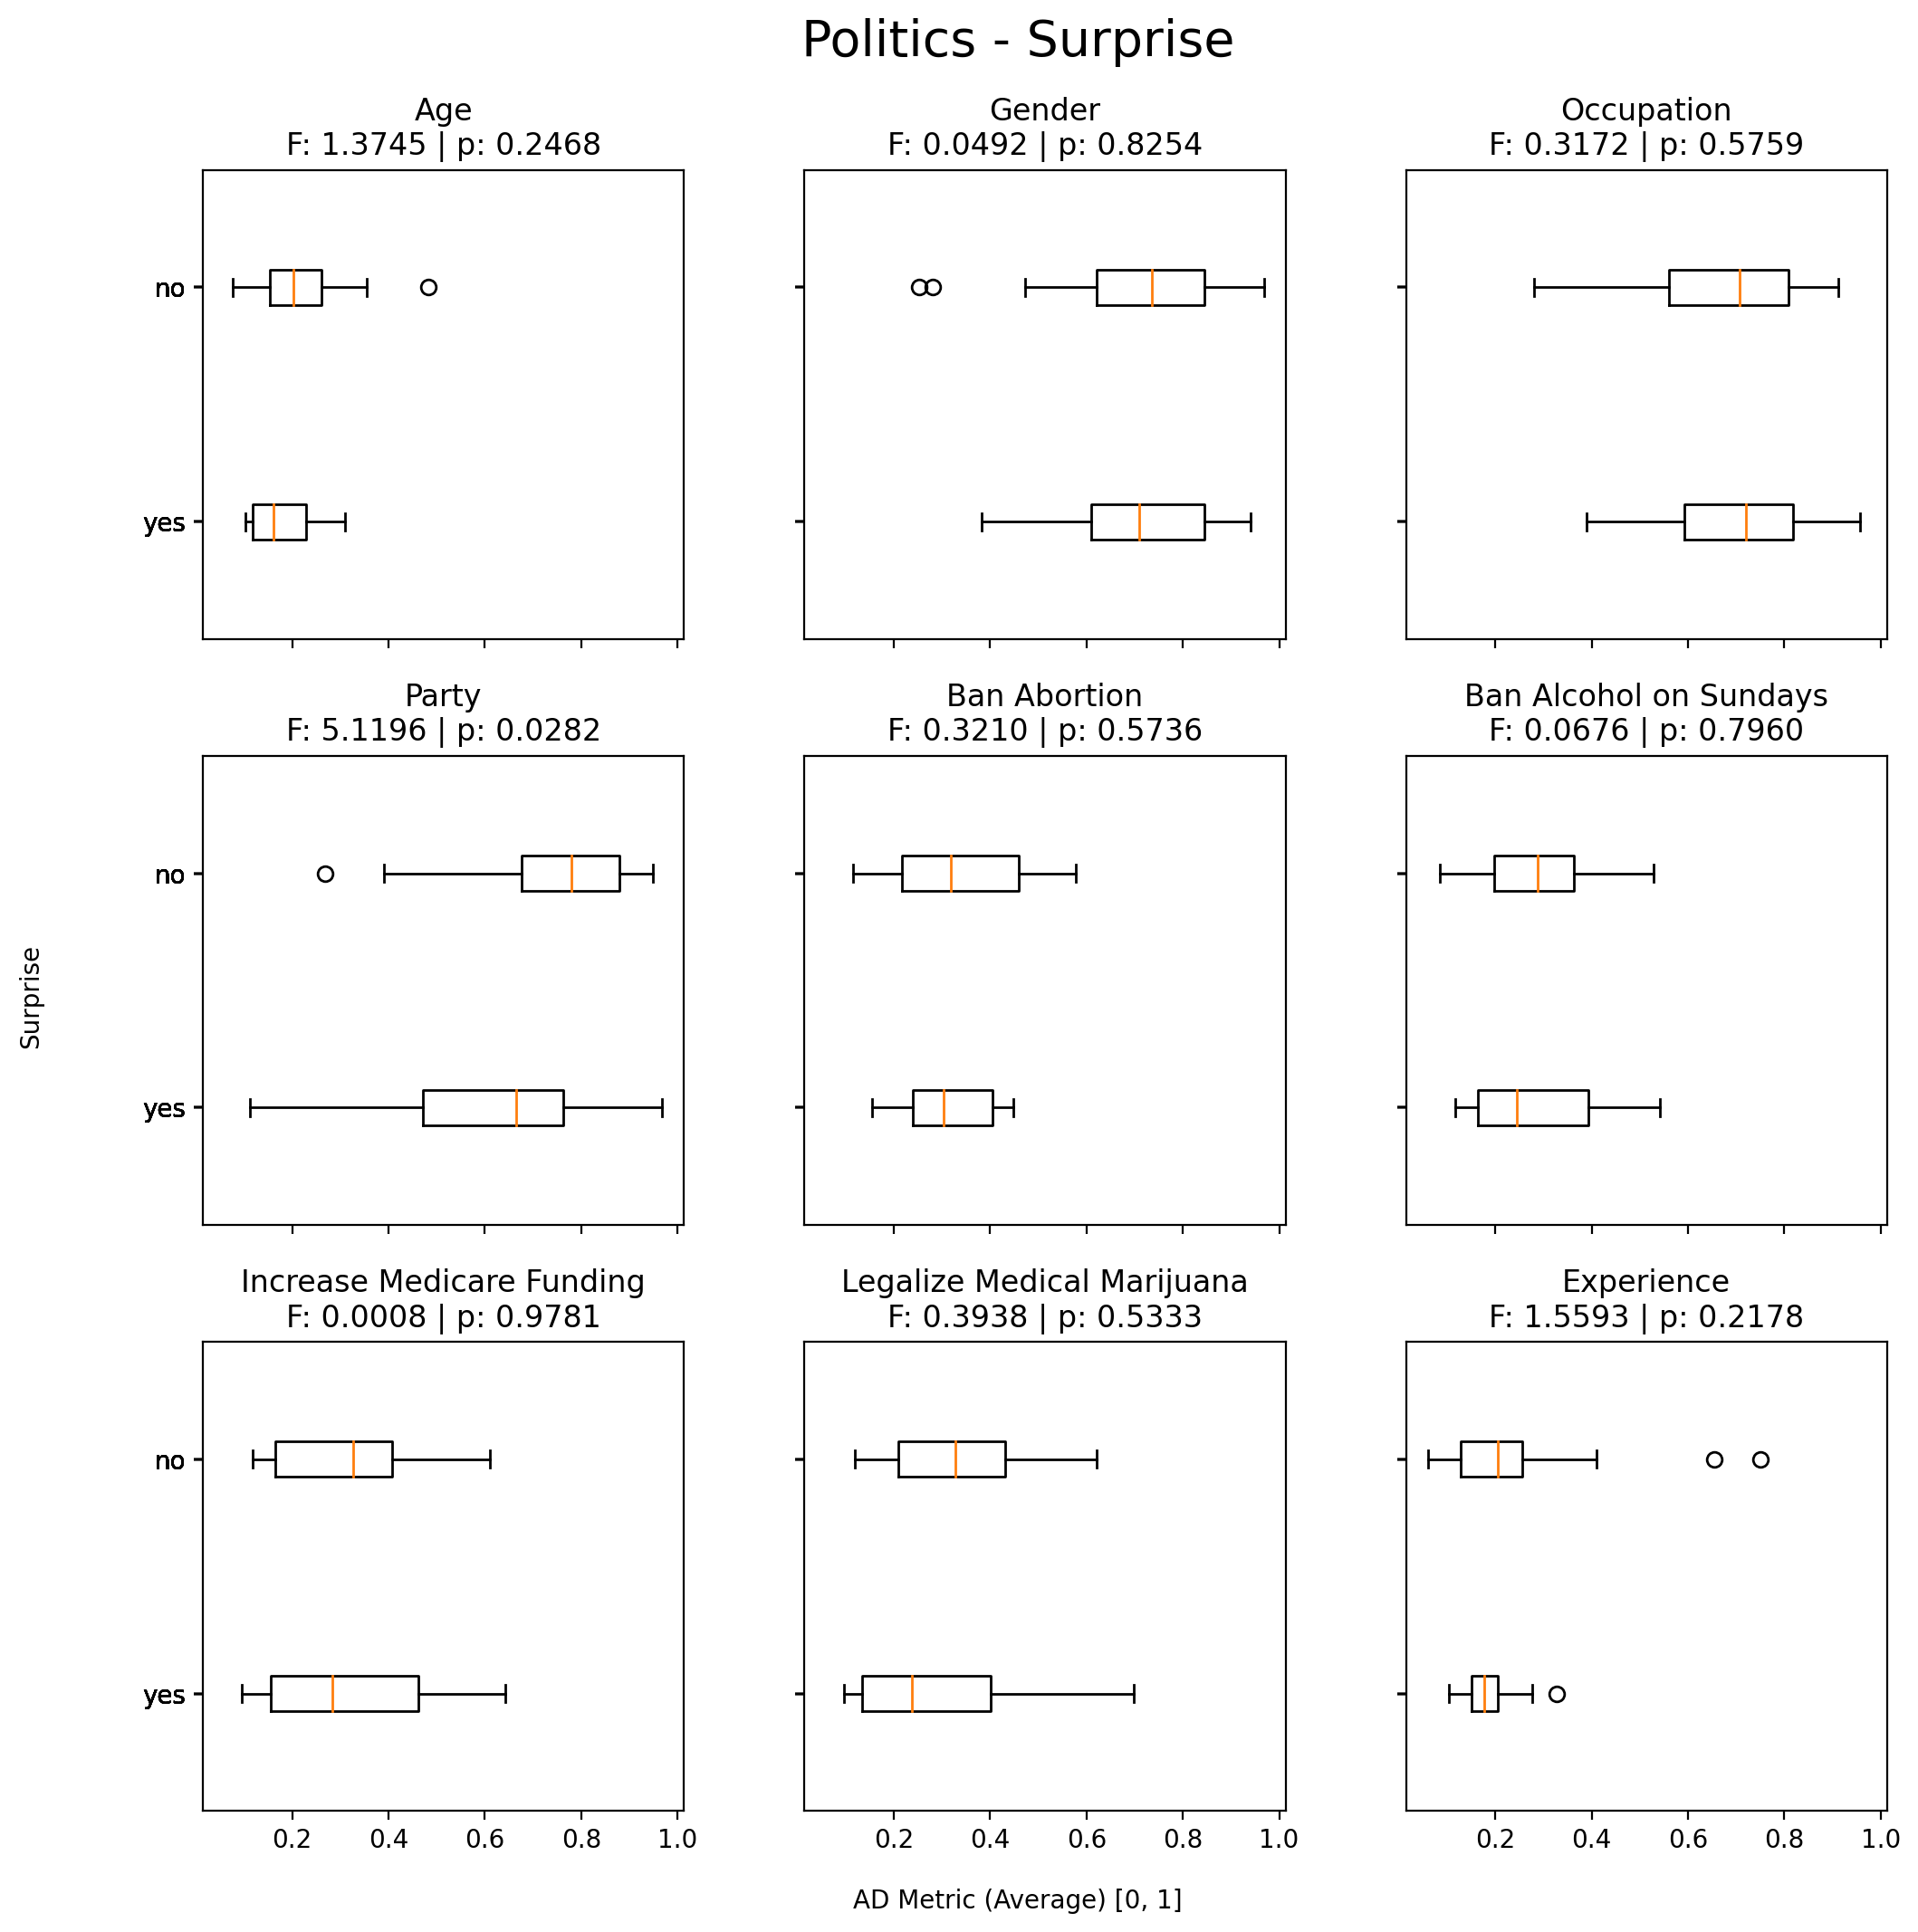

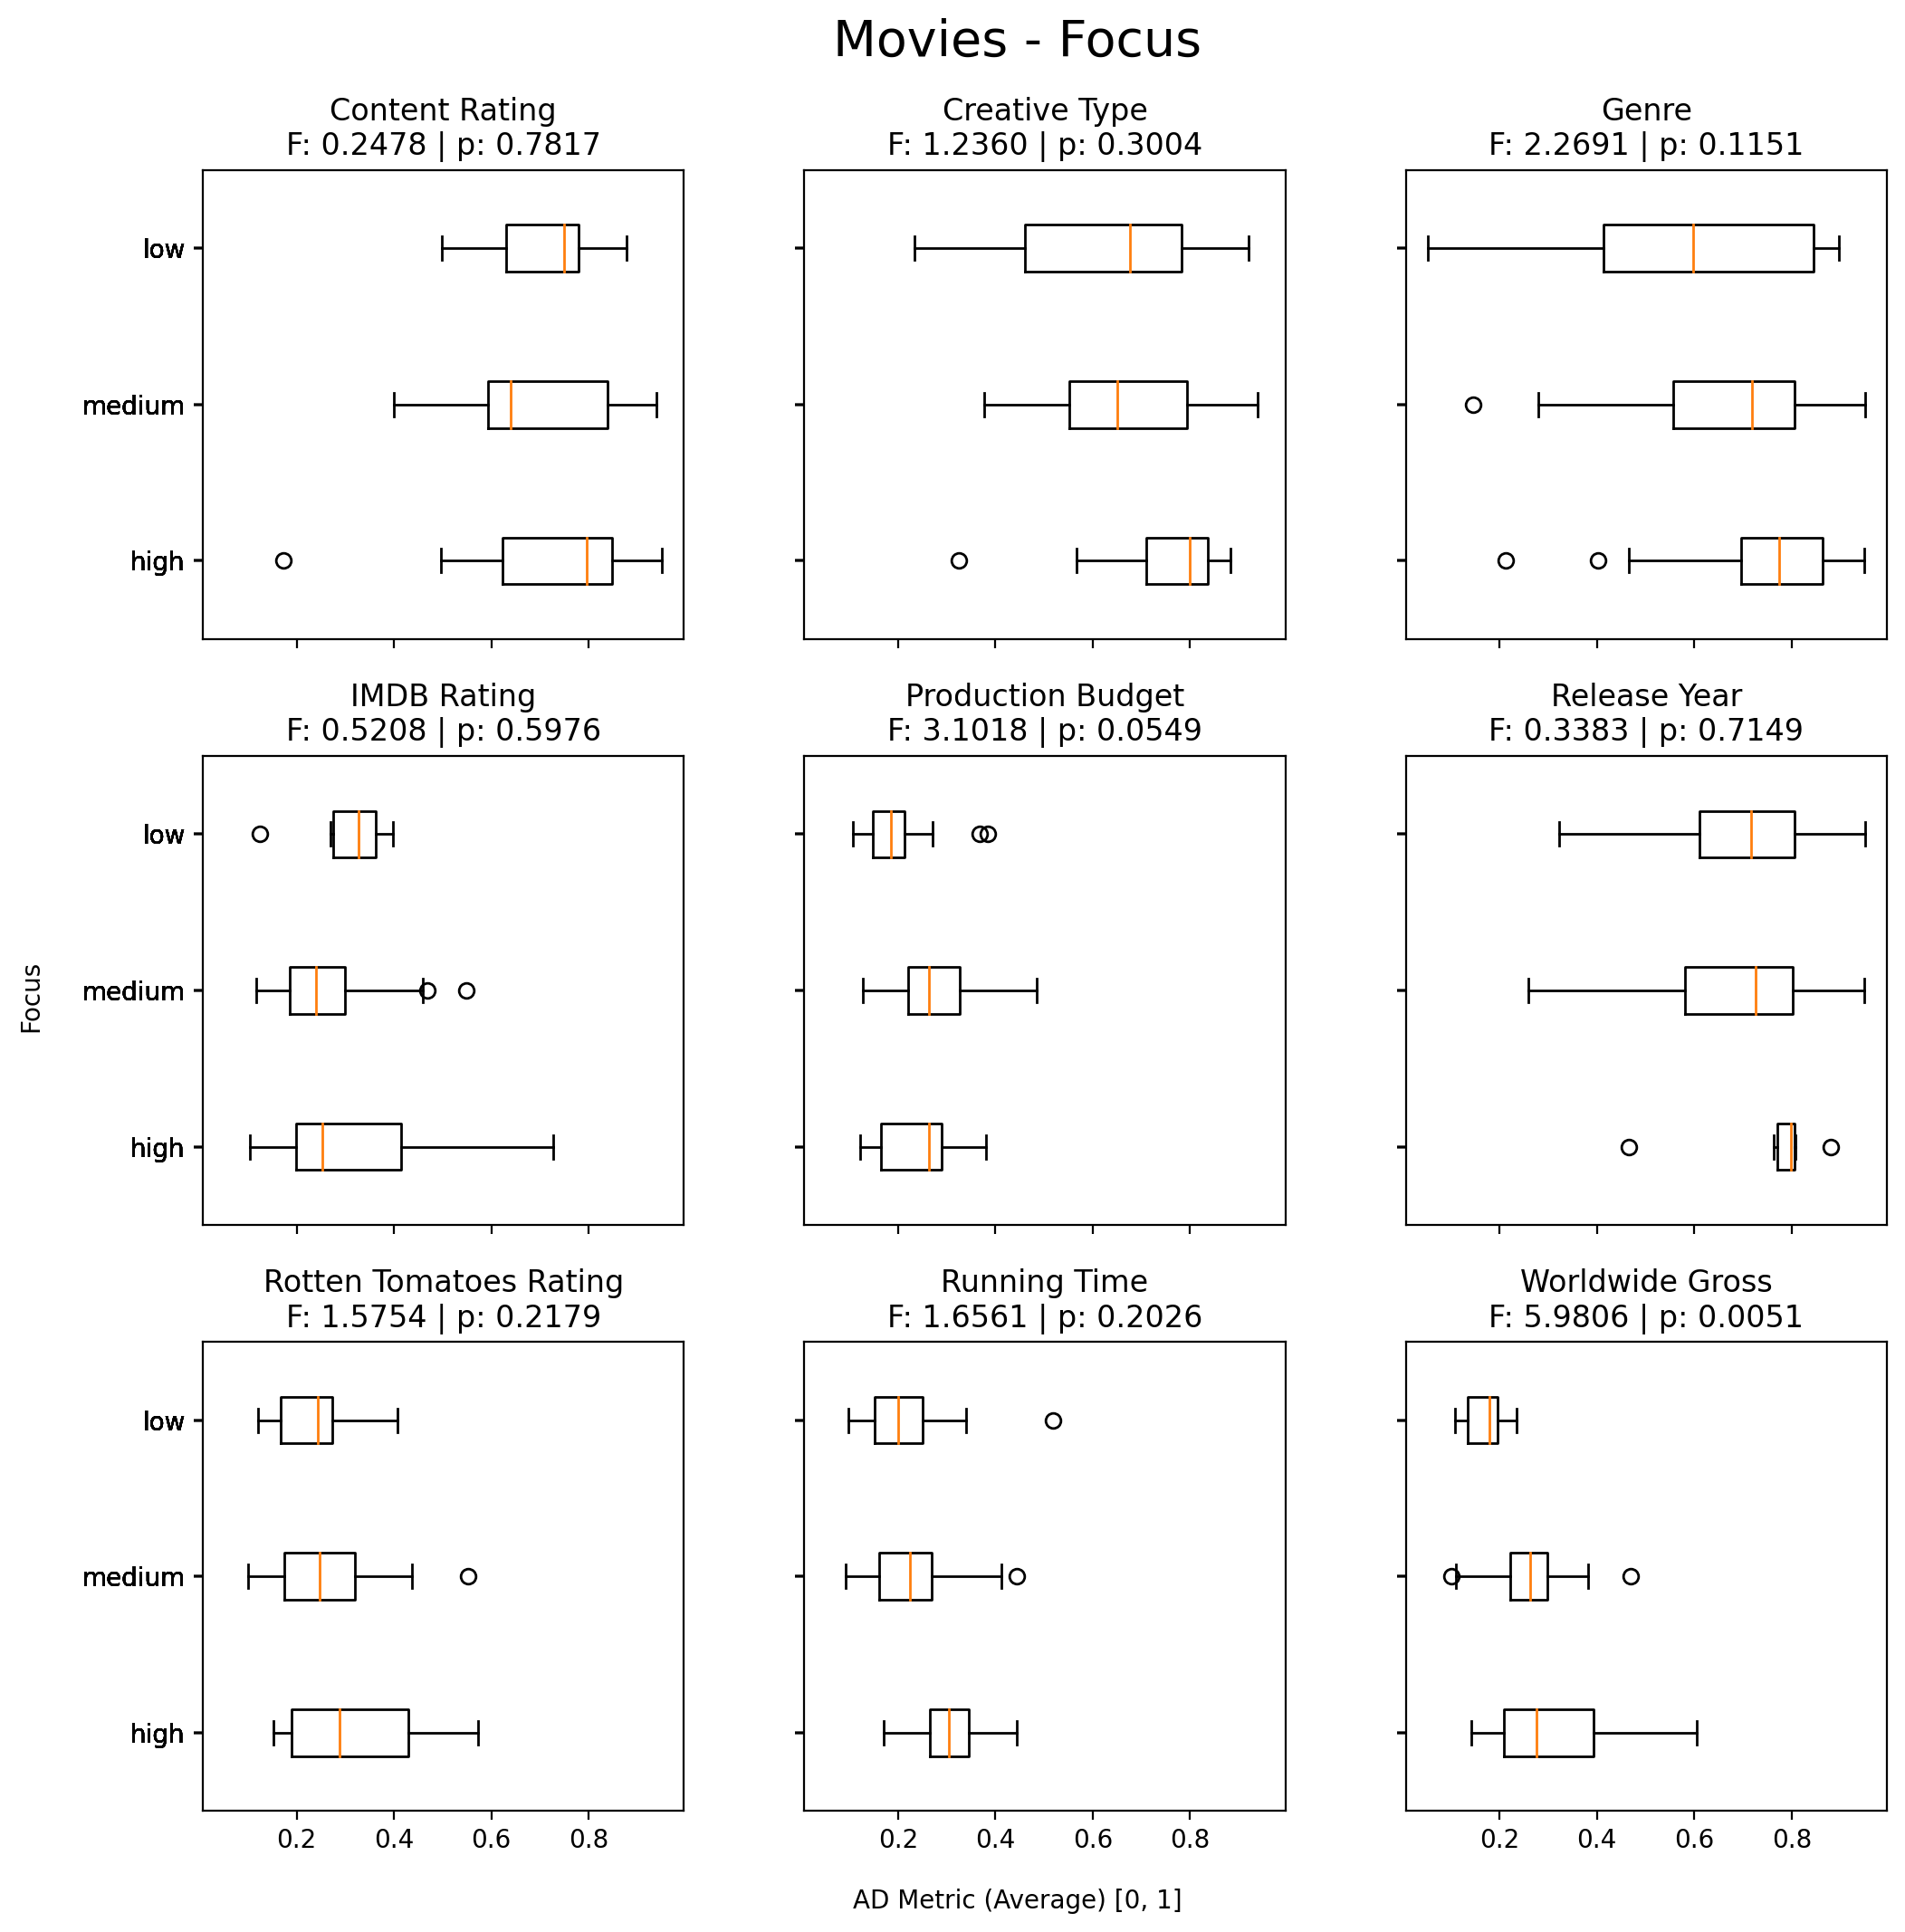

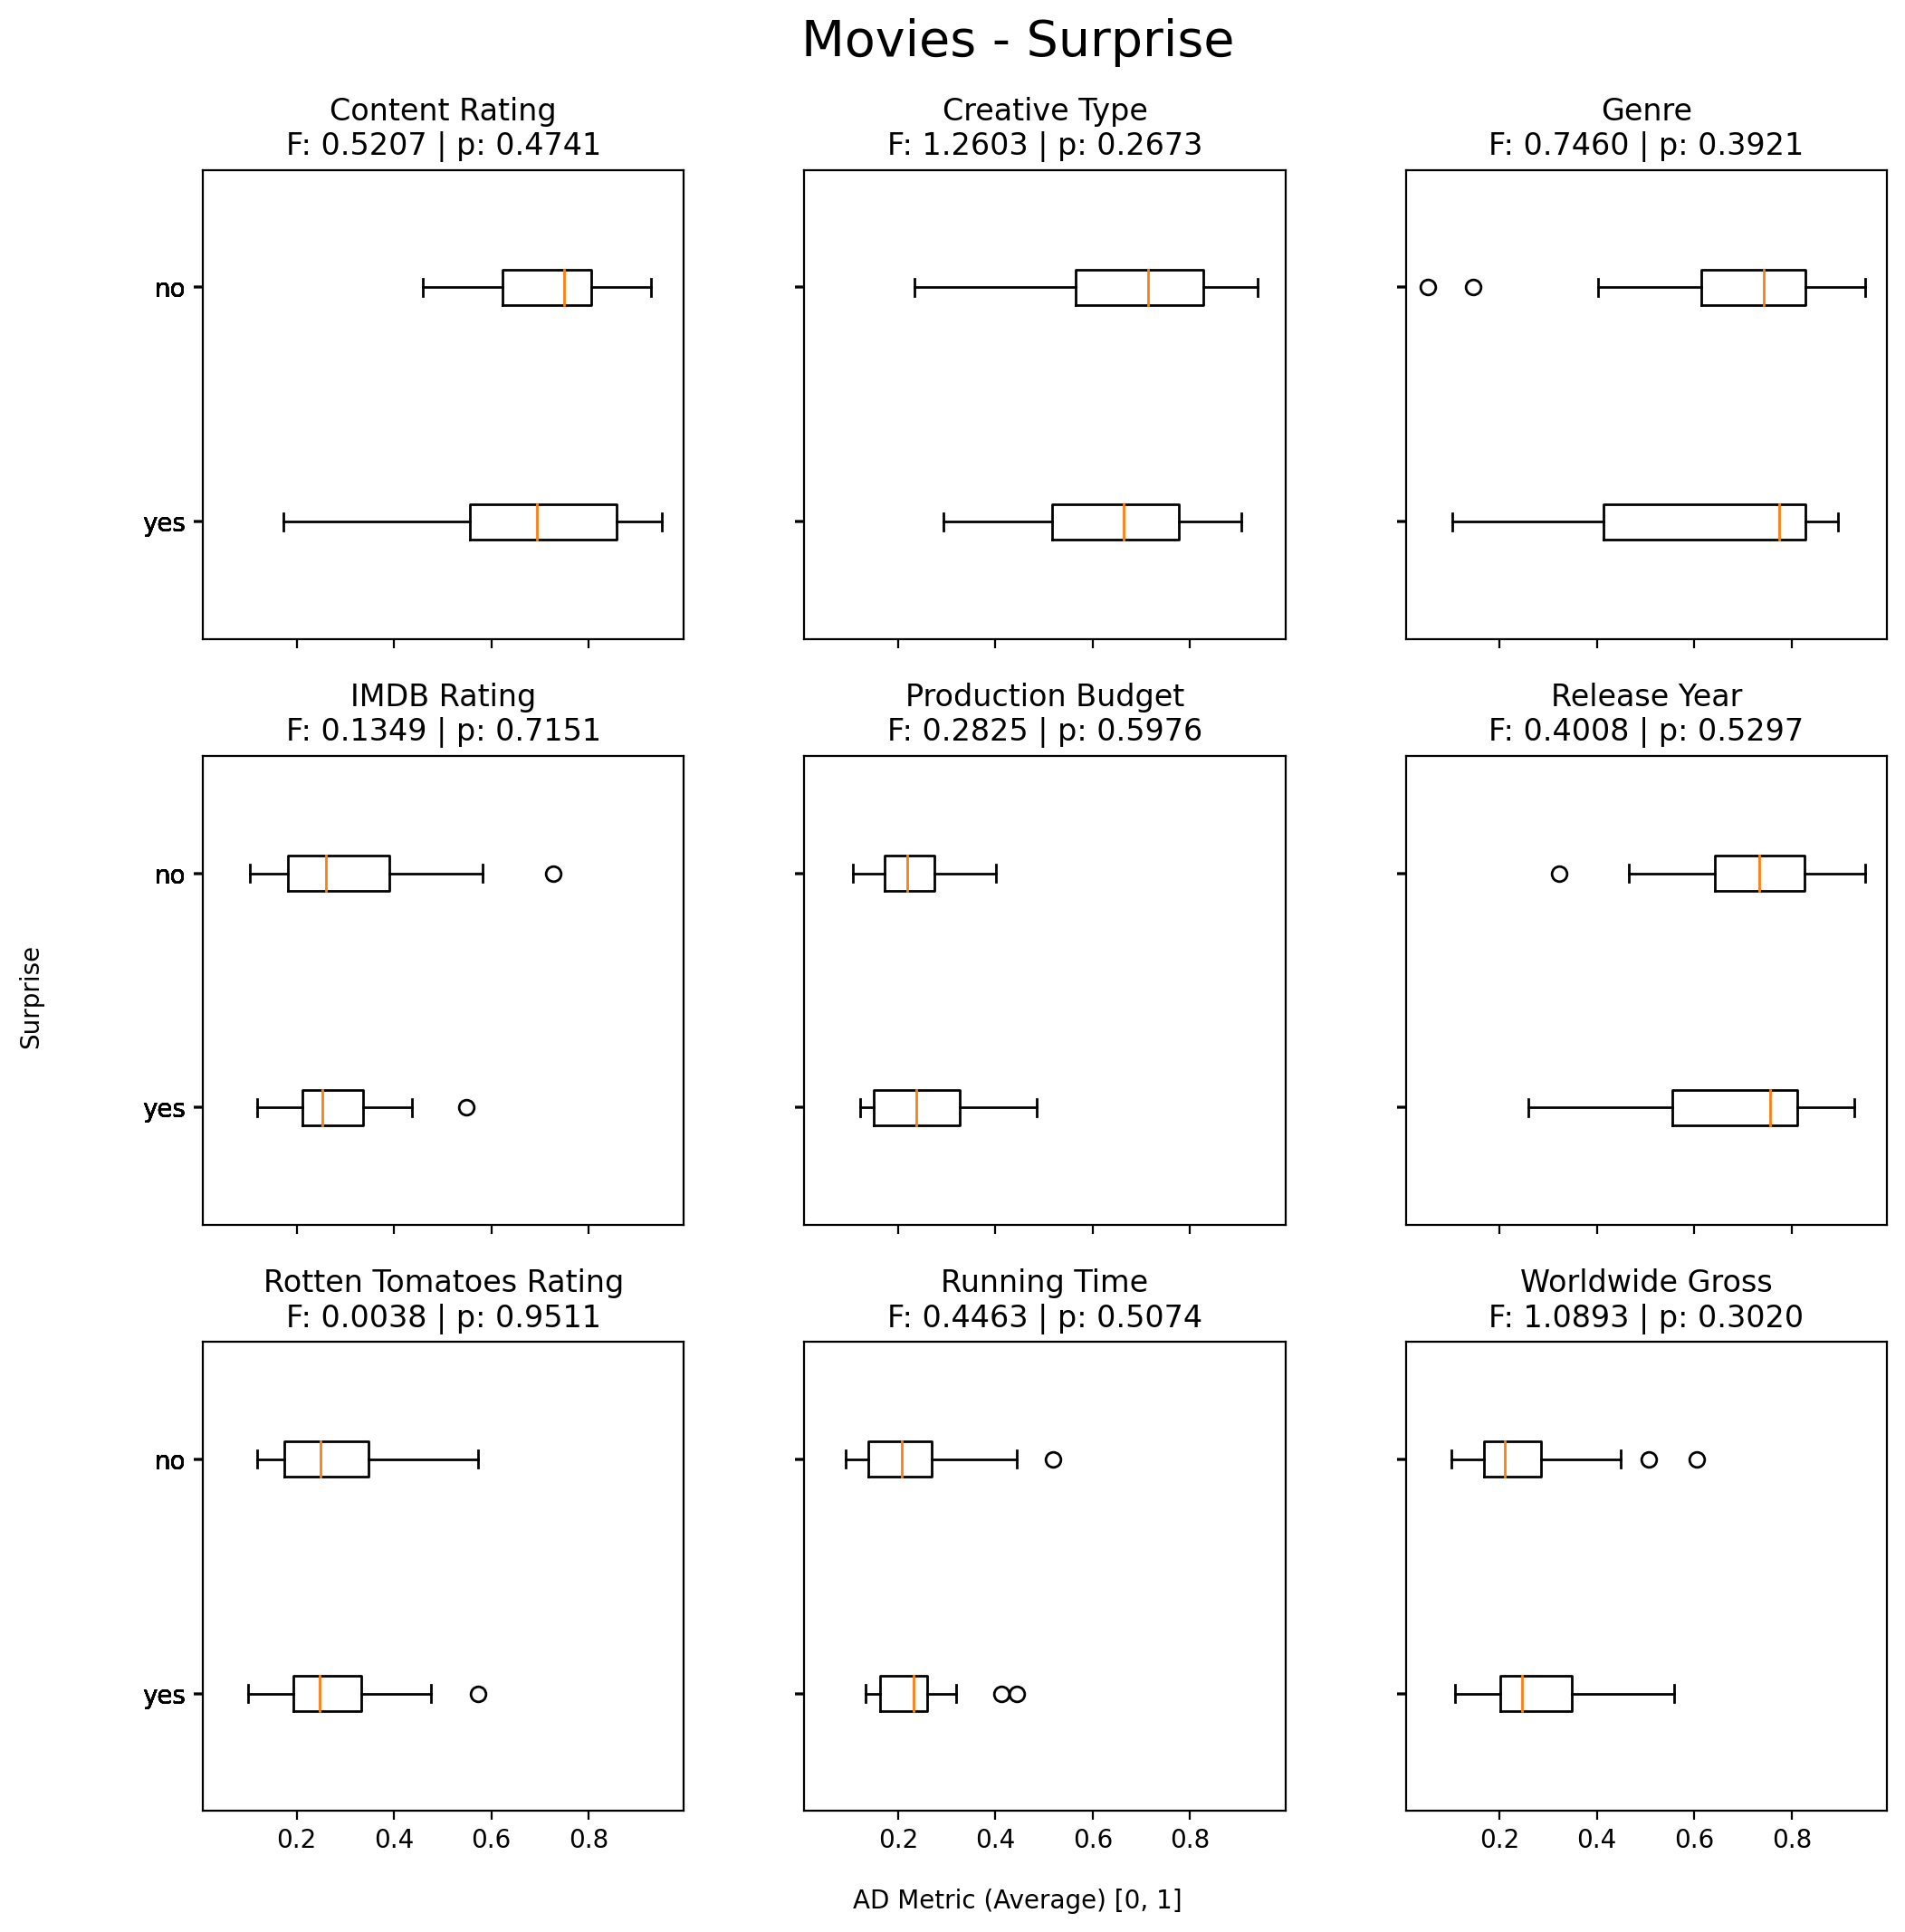

In [7]:
# set this
metric = 'ad_metric_avg'

row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    for measure in ['focus', 'surprise']:
        sf_dfs = []
        ad_dfs = []
        for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
            PIDS = ALL_PIDS[condition]

            ### SURPRISE/FOCUS ###

            for pid in PIDS:
                # get file
                basepath = os.path.join(condition, pid)  # basepath for PID
                try:
                    df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                    appOrder = "PM"
                except FileNotFoundError:
                    df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                    appOrder = "MP"

                # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
                if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                    # append surprise/focus counts
                    sf_dfs.append(
                        df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                            .apply(pd.Series).T[row_index[task]]
                            .map(lambda x: ast.literal_eval(str(x)))
                            .apply(pd.Series)
                            .reset_index()
                            .rename(columns={'index': 'attribute'})
                            .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                    )

                    ad_dfs.append(
                        pd.read_csv(os.path.join(basepath, f"attr_stats_{task}.csv"))
                            .assign(PID=lambda x: pid)[['PID', 'attribute', 'ad_metric_final', 'ad_metric_avg']]
                    )

        # push the dataframes together and join on ['PID', 'attribute']
        surprise_focus = pd.concat(sf_dfs, ignore_index=True)
        ad_metric = pd.concat(ad_dfs, ignore_index=True)
        df_measures = (
            surprise_focus.set_index(['PID', 'attribute']).join(ad_metric.set_index(['PID', 'attribute'])).reset_index()
        )

        ### PLOT ###

        labels = {
            'focus': ['high', 'medium', 'low'],
            'surprise': ['yes', 'no'],
        }
        plot_titles = {
            'politics': {
                'age': 'Age',
                'gender': 'Gender',
                'occupation': 'Occupation',
                'party': 'Party',
                'political_experience': 'Experience',
                'policy_strength_ban_abortion_after_6_weeks': 'Ban Abortion',
                'policy_strength_legalize_medical_marijuana': 'Legalize Medical Marijuana',
                'policy_strength_increase_medicare_funding': 'Increase Medicare Funding',
                'policy_strength_ban_alcohol_sales_sundays': 'Ban Alcohol on Sundays'
            },
            'movies': {
                "Running Time": "Running Time",
                "Production Budget": "Production Budget",
                "Worldwide Gross": "Worldwide Gross",
                "Rotten Tomatoes Rating": "Rotten Tomatoes Rating",
                "IMDB Rating": "IMDB Rating",
                "Genre": "Genre",
                "Creative Type": "Creative Type",
                "Content Rating": "Content Rating",
                "Release Year": "Release Year",
            }
        }

        total_rows = 3
        total_cols = 3
        fig, ax = plt.subplots(nrows=total_rows, ncols=total_rows, sharex=True, sharey=True, figsize=(12,12))
        plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

        countrow = 0
        countcol = 0
        for key, grp in df_measures.groupby(['attribute']):
            vals = grp.groupby(measure)[metric].apply(list).reindex(labels[measure]).fillna("").apply(list)

            # Perform ANOVA 1-way test
            f_stat, p_val = f_oneway(*vals)

            # Plot the summary
            ax_curr = ax[countrow][countcol]
            ax_curr.boxplot(vals, vert=False, labels=labels[measure])
            ax_curr.set_title(f"{plot_titles[task][key]}\nF: {f_stat:.04f} | p: {p_val:.04f}")
            countcol += 1
            if (countcol == total_cols):
                countcol = 0
                countrow += 1
                if (countrow == total_rows):
                    break 

        xlabel_text = {
            'ad_metric_avg': 'AD Metric (Average) [0, 1]',
            'ad_metric_final': 'AD Metric (Final) [0, 1]',
            'ac_metric_avg': 'AC Metric (Average) [0, 1]',
            'ac_metric_final': 'AC Metric (Final) [0, 1]',
        }
        fig.text(0.5, 0.08, xlabel_text[metric], ha='center')
        fig.text(0.04, 0.5, measure.capitalize(), va='center', rotation='vertical')
        
        fig.suptitle(f'{task.capitalize()} - {measure.capitalize()}', x=0.5, y=0.95, fontsize=20)

        plt.subplots_adjust(hspace=0.25, wspace=0.25)
        
#         plt.savefig(f'charts/surprise/{task}/{task}_{metric}_by_{measure}.png', dpi=300, bbox_inches='tight')
#         plt.close(fig)

# ANOVA - Average Attribute AD Metric - Grouped by Focus/Surprise - Across All Conditions - For Select Attributes

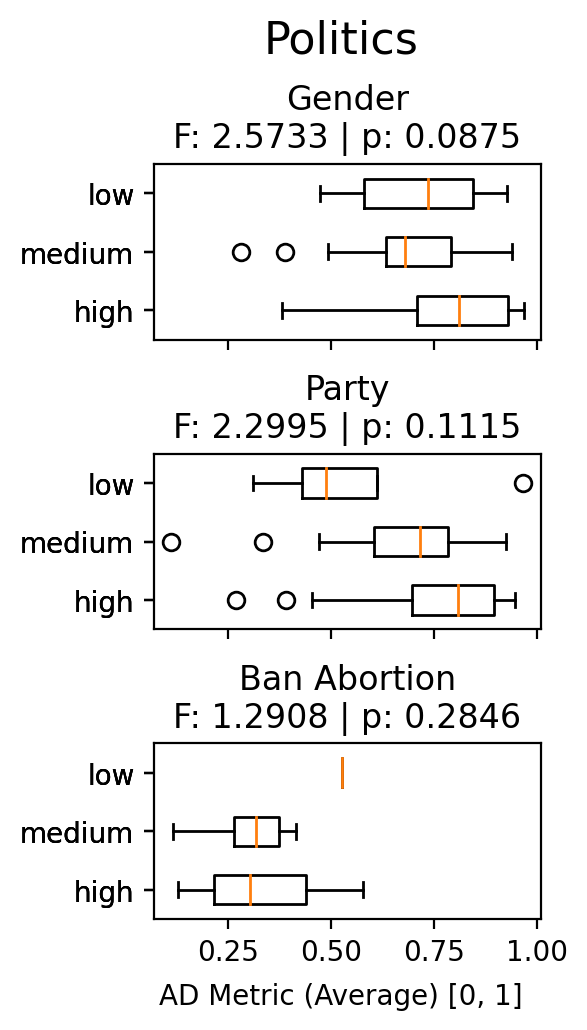

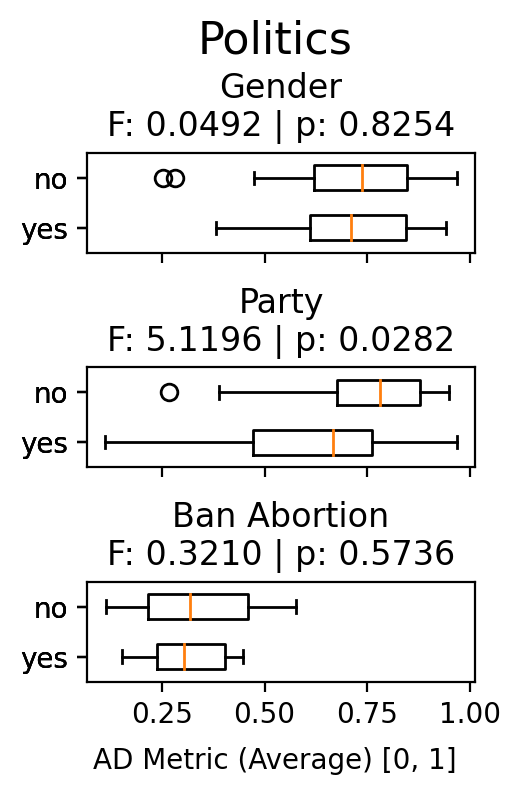

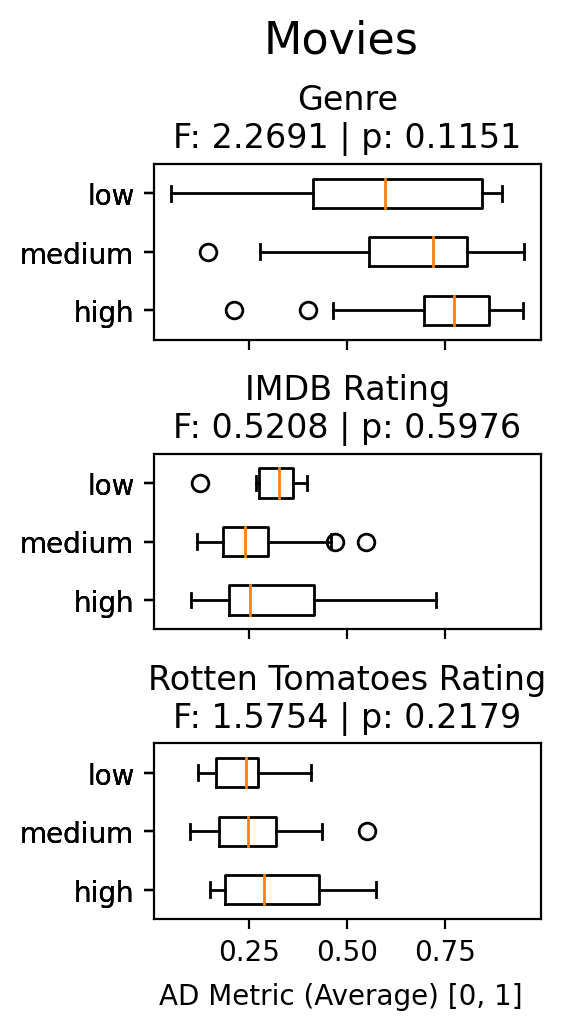

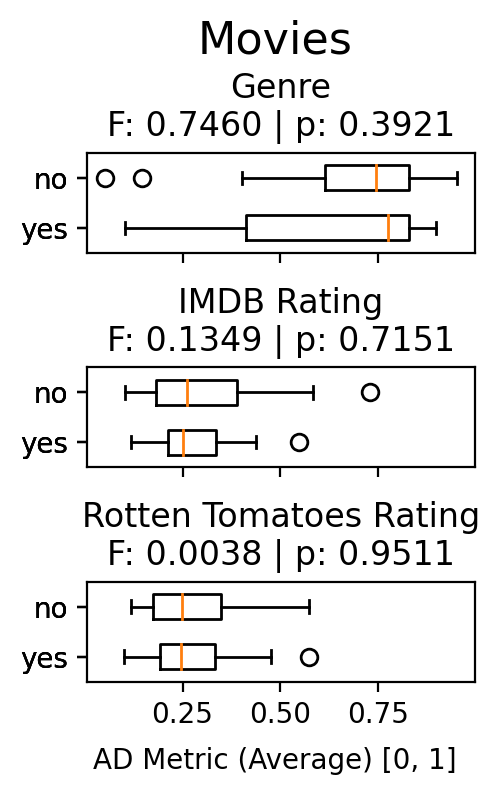

In [8]:
metric = "ad_metric_avg"
attrs = {
    'politics': ['gender', 'party', 'policy_strength_ban_abortion_after_6_weeks'],
    'movies': ['IMDB Rating', 'Genre', 'Rotten Tomatoes Rating'],
}
row_index = {
    'politics': 1,
    'movies': 0,
}

for task in ['politics', 'movies']:
    for measure in ['focus', 'surprise']:
        sf_dfs = []
        ad_dfs = []
        for condition in ['CTRL', 'SUM', 'RT', 'RTSUM']:
            PIDS = ALL_PIDS[condition]

            ### SURPRISE/FOCUS ###

            for pid in PIDS:
                # get file
                basepath = os.path.join(condition, pid)  # basepath for PID
                try:
                    df = pd.read_csv(os.path.join(basepath, f"task_PM.csv"))
                    appOrder = "PM"
                except FileNotFoundError:
                    df = pd.read_csv(os.path.join(basepath, f"task_MP.csv"))
                    appOrder = "MP"

                # user 'rJwpqBcwhEar' RTSUM MP missing movies surprise/focus, skip them
                if not (pid == 'rJwpqBcwhEar' and task == 'movies'):

                    # append surprise/focus counts
                    sf_dfs.append(
                        df[df['task'] == task]['surprise_focus'].map(lambda x: ast.literal_eval(str(x)))
                            .apply(pd.Series).T[row_index[task]]
                            .map(lambda x: ast.literal_eval(str(x)))
                            .apply(pd.Series)
                            .reset_index()
                            .rename(columns={'index': 'attribute'})
                            .assign(PID=lambda x: pid)[['PID', 'attribute', 'focus', 'surprise']]
                    )

                    ad_dfs.append(
                        pd.read_csv(os.path.join(basepath, f"attr_stats_{task}.csv"))
                            .assign(PID=lambda x: pid)[['PID', 'attribute', 'ad_metric_final', 'ad_metric_avg']]
                    )

        # push the dataframes together and join on ['PID', 'attribute']
        surprise_focus = pd.concat(sf_dfs, ignore_index=True)
        ad_metric = pd.concat(ad_dfs, ignore_index=True)
        df_measures = (
            surprise_focus.set_index(['PID', 'attribute']).join(ad_metric.set_index(['PID', 'attribute'])).reset_index()
        )

        df_measures = df_measures[df_measures['attribute'].isin(attrs[task])]

        ### PLOT ###

        labels = {
            'focus': ['high', 'medium', 'low'],
            'surprise': ['yes', 'no'],
        }
        plot_titles = {
            'politics': {
                'age': 'Age',
                'gender': 'Gender',
                'occupation': 'Occupation',
                'party': 'Party',
                'political_experience': 'Experience',
                'policy_strength_ban_abortion_after_6_weeks': 'Ban Abortion',
                'policy_strength_legalize_medical_marijuana': 'Legalize Medical Marijuana',
                'policy_strength_increase_medicare_funding': 'Increase Medicare Funding',
                'policy_strength_ban_alcohol_sales_sundays': 'Ban Alcohol on Sundays'
            },
            'movies': {
                "Running Time": "Running Time",
                "Production Budget": "Production Budget",
                "Worldwide Gross": "Worldwide Gross",
                "Rotten Tomatoes Rating": "Rotten Tomatoes Rating",
                "IMDB Rating": "IMDB Rating",
                "Genre": "Genre",
                "Creative Type": "Creative Type",
                "Content Rating": "Content Rating",
                "Release Year": "Release Year",
            }
        }


        if measure == 'focus':
            figsize = (2.5, 5)
        elif measure == 'surprise':
            figsize = (2.5, 3.5)

        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=figsize)
        plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

        countrow = 0
        for key, grp in df_measures.groupby(['attribute']):
            # Get values
            vals = grp.groupby(measure)[metric].apply(list).reindex(labels[measure]).fillna("").apply(list)

            # Perform ANOVA 1-way test
            f_stat, p_val = f_oneway(*vals)

            # Plot the summary
            ax_curr = ax[countrow]
            ax_curr.boxplot(vals, vert=False, labels=labels[measure], widths=[0.5 for _ in range(len(labels[measure]))])
            ax_curr.set_title(f"{plot_titles[task][key]}\nF: {f_stat:.04f} | p: {p_val:.04f}")
            countrow += 1

        # Label text
        xlabel_text = {
            'ad_metric_avg': 'AD Metric (Average) [0, 1]',
            'ad_metric_final': 'AD Metric (Final) [0, 1]',
            'ac_metric_avg': 'AC Metric (Average) [0, 1]',
            'ac_metric_final': 'AC Metric (Final) [0, 1]',
        }

        if measure == 'focus':
            fig.text(0.5, 0.04, xlabel_text[metric], ha='center')
            plt.subplots_adjust(hspace=0.65)
            fig.suptitle(task.capitalize(), x=0.5, y=1.025, fontsize=16)
        elif measure == 'surprise':
            fig.text(0.5, 0.00, xlabel_text[metric], ha='center')
            plt.subplots_adjust(hspace=1.15)
            fig.suptitle(task.capitalize(), x=0.5, y=1.07, fontsize=16)
    

#     plt.savefig(f'charts/surprise/{task}/{task}_{metric}_by_{measure}_PAPER.png', dpi=300, bbox_inches='tight')
#     plt.close(fig)